# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Student Name {-}
Nguyen Thai Thao Uyen

### Deadline {-}
2023-May-26

#  📈 Nasdaq stock price prediction

* Nasdaq stock price prediction, i.e., how much the price
increases/decreases in a certain time window.
* How does the price change in different time windows, e.g., one day,
one week/seven days in a row, one month/thirty days in a row, etc.?




### Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [54]:
def return_rmse(test, predicted):
    rmse = np.round(math.sqrt(mean_squared_error(test, predicted)),1)
    print("Root Mean Squared Error (RMSE): {}".format(rmse))

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [57]:
def calculate_ema(data, period):
    weights = pd.Series([(1 - 0.5)**i for i in range(period)])
    ema = data.ewm(span=period, adjust=False).mean()
    return ema

# NASDAQ - APPLE (AAPL)

#### Data Exploration

In [4]:
import yfinance as yf
df = yf.download(tickers = 'AAPL', start = '2012-03-11',end = '2022-07-10')
df.head(10)

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close      Volume
Date                                                                         
2012-03-12  19.606428  19.714287  19.535713  19.714287  16.756018   407282400
2012-03-13  19.912144  20.292143  19.848213  20.289286  17.244738   690855200
2012-03-14  20.644644  21.240000  20.549999  21.056429  17.896757  1418844000
2012-03-15  21.414642  21.428928  20.662500  20.912857  17.774731  1159718000
2012-03-16  20.882856  21.042856  20.642857  20.913214  17.775032   825487600
2012-03-19  21.370358  21.491785  21.037500  21.467857  18.246443   901236000
2012-03-20  21.411072  21.674999  21.124287  21.641430  18.393982   816662000
2012-03-21  21.526428  21.773214  21.478930  21.517857  18.288946   644042000
2012-03-22  21.349285  21.589287  21.268929  21.405001  18.193022   623870800
2012-03-23  21.446072  21.492857  21.228571  21.287500  18.093153   430488800

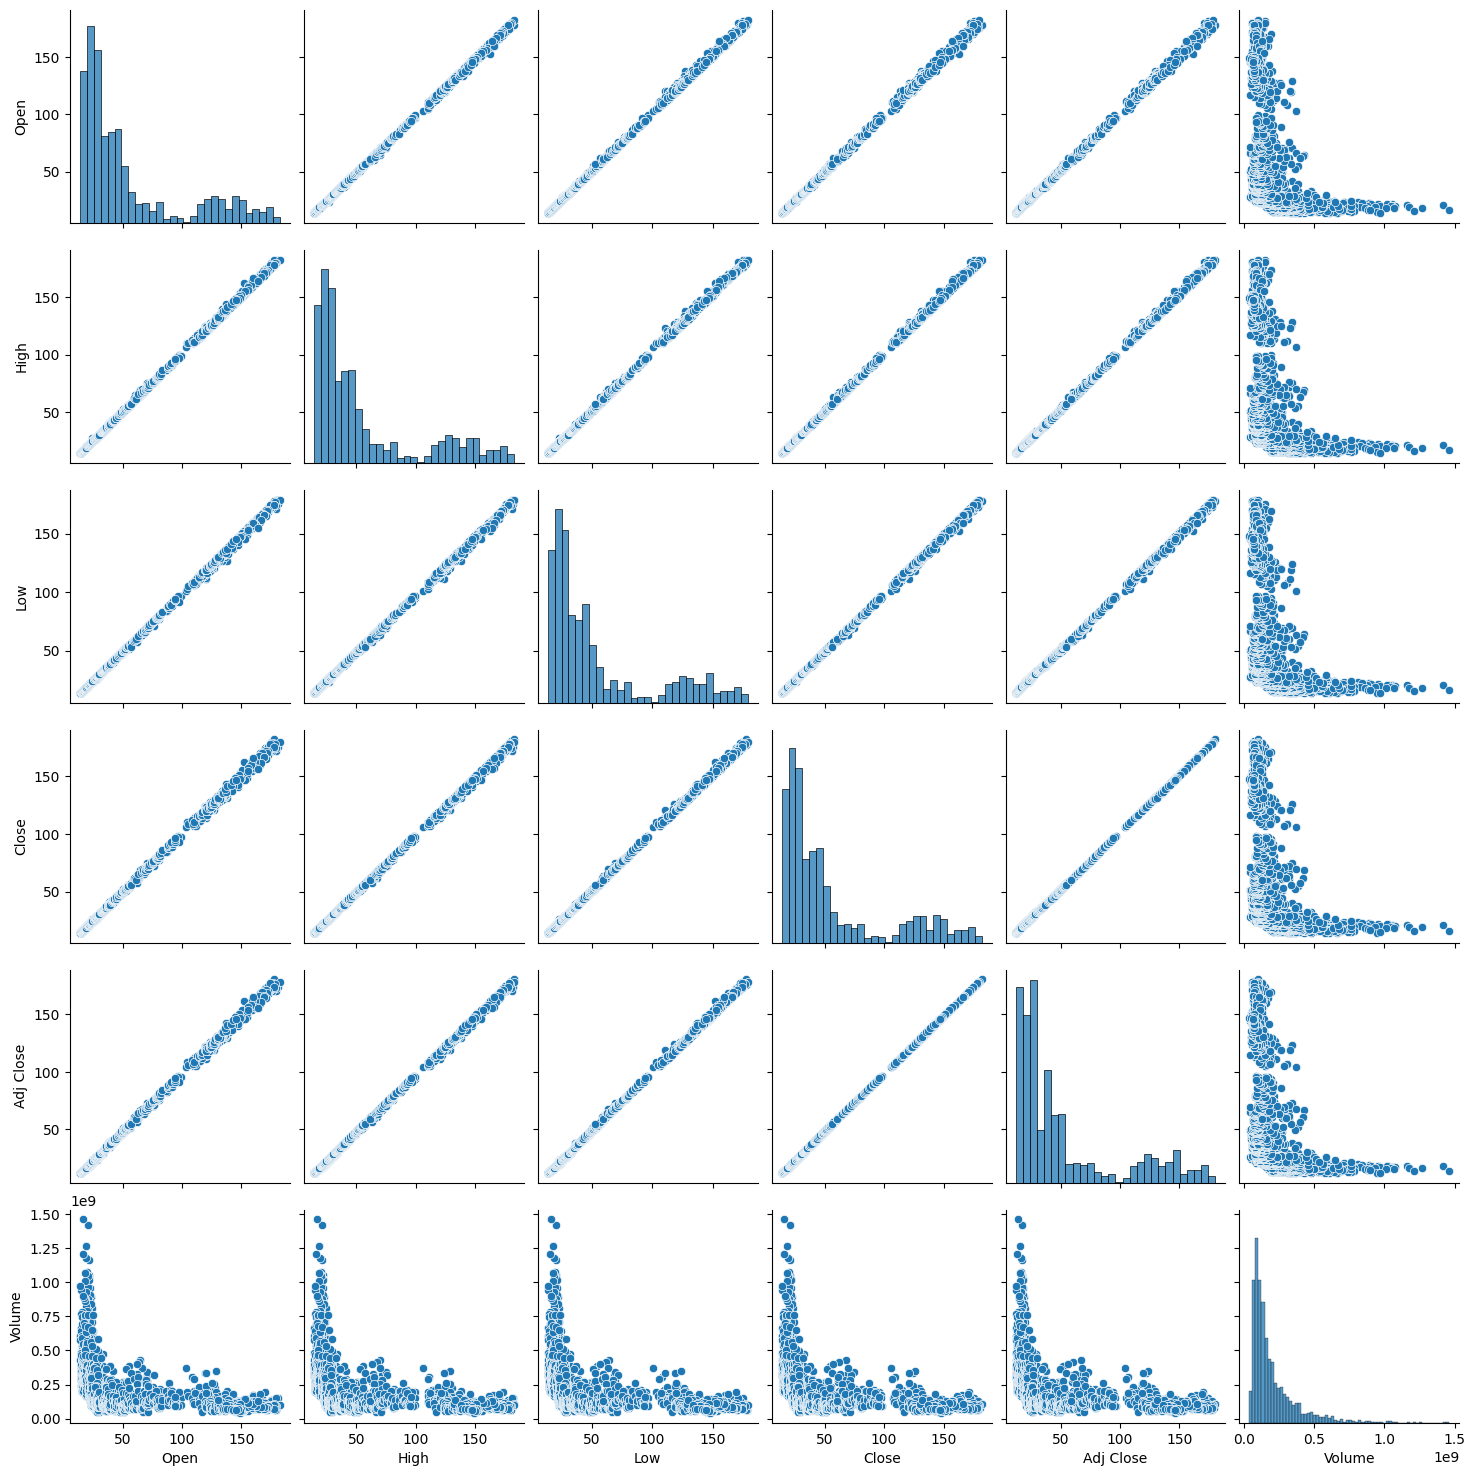

In [5]:
sns.pairplot(df)

In [239]:
df['Target'] = df['Adj Close']- df['Open']        # How much price has moved up or down
df['TargetNextClose'] = df['Adj Close'].shift(-1)
df.head(10)

Open       High        Low      Close  Adj Close      Volume  \
Date                                                                            
2012-03-12  19.606428  19.714287  19.535713  19.714287  16.756012   407282400   
2012-03-13  19.912144  20.292143  19.848213  20.289286  17.244730   690855200   
2012-03-14  20.644644  21.240000  20.549999  21.056429  17.896759  1418844000   
2012-03-15  21.414642  21.428928  20.662500  20.912857  17.774731  1159718000   
2012-03-16  20.882856  21.042856  20.642857  20.913214  17.775032   825487600   
2012-03-19  21.370358  21.491785  21.037500  21.467857  18.246449   901236000   
2012-03-20  21.411072  21.674999  21.124287  21.641430  18.393980   816662000   
2012-03-21  21.526428  21.773214  21.478930  21.517857  18.288952   644042000   
2012-03-22  21.349285  21.589287  21.268929  21.405001  18.193026   623870800   
2012-03-23  21.446072  21.492857  21.228571  21.287500  18.093155   430488800   

              Target  TargetNextClose  
Date                                   
2012-03-12 -2.850416        17.244730  
2012-03-13 -2.667414        17.896759  
2012-03-14 -2.747885        17.774731  
2012-03-15 -3.639912        17.775032  
2012-03-16 -3.107824        18.246449  
2012-03-19 -3.123909        18.393980  
2012-03-20 -3.017092        18.288952  
2012-03-21 -3.237476        18.193026  
2012-03-22 -3.156260        18.093155  
2012-03-23 -3.352917        18.424932

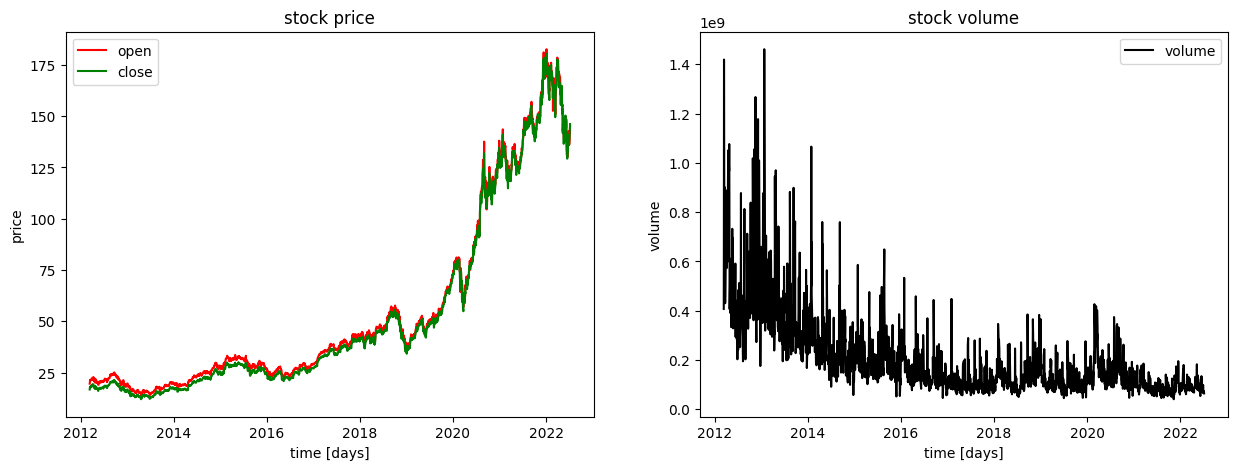

In [7]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df['Open'], color='red', label='open')
plt.plot(df['Adj Close'], color='green', label='close')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()
plt.subplot(1,2,2);
plt.plot(df['Volume'], color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [6]:
from itertools import cycle
import plotly.express as px
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(df, x=df.index, y=[df['Open'], df['Adj Close'], 
                                          df['High'], df['Low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock price history', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### 1 day prediction

#### -- Train Test Set

In [14]:
df.columns[0]

'Open'

In [20]:
"""
Input features (X):
- Window: 30 days of historical data
Labels (y):
- The stock price 1 day after the last day in each window
"""
import numpy as np

X_data = []
y_data = []
window_size = 30
prediction_days = 0

for i in range(len(df) - window_size - prediction_days +1):
    data_feature = []
    data_label = []
    
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 2])  # Assuming column index 2 is the open price
    
    # This ensures that the label corresponds to the stock price 7 days after the last day in each window.
    data_label.append(df.iloc[i + window_size + prediction_days - 1, 2])
    
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_test = X_test.shape[0]

# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

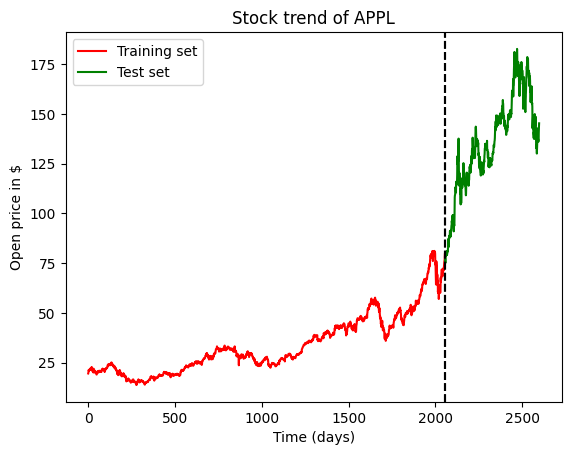

In [21]:
# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of APPL")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.show()

#### -- RNN Model

In [22]:
### Create and train the model

# Import libraries
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout


# Initialize a sequential model since all the layers in the model only have single input and produce single output
# Define the RNN model
RNN_model = Sequential()
RNN_model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
RNN_model.add(Dropout(0.20))
RNN_model.add(LSTM(50))
RNN_model.add(Dropout(0.20))
RNN_model.add(Dense(32, activation='relu'))
RNN_model.add(Dense(y_train.shape[1])) # Output layer, adjust output_dim accordingly


# Summarize the model
RNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1632      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32,265
Trainable params: 32,265
Non-trai

##### -- Start running the model

In [23]:
# RUN THE CROSS VALIDATION (5 Folds)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statistics

tscv = TimeSeriesSplit()
loss_result = []
count = 1
for train_index, val_index in tscv.split(X_train_norm):
    x_train, y_train = X_train_norm[train_index], y_train_norm[train_index]
    x_val, y_val = X_train_norm[val_index], y_train_norm[val_index]
    # Compile and train the model with Mean Squared Error loss function
    RNN_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='mse', 
                          metrics=['mse'])
    history = RNN_model.fit(X_train_norm, y_train_norm, validation_data=(x_val,y_val), epochs=100, batch_size=32)
    
    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    # Get prediction on the test data
    y_predict = RNN_model.predict(x_val)
    loss_result.append(mean_squared_error(y_val,y_predict))
    
    print("COMPLETE",count,'/32')
    count += 1

# Calculate the average evaluation metrics across all folds
print("AVERAGE MSE ACROSS ALL FOLDS: ", statistics.mean(loss_result))

Epoch 1/100
65/65 [==============================] - 5s 14ms/step - loss: 0.1172 - mse: 0.1172 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 2/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/100
65/65 [==============================] - 0s 6ms/step - loss: 0.0066 - 

In [26]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = RNN_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

17/17 [==============================] - 0s 9ms/step
MSE on the test set:  0.003021315828854927


In [27]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

#### -- Visualizing the results

In [28]:
# Store prediction values
openPred1 = []
for val in y_pred_denorm:
  for i in val:
    openPred1.append(i)
print(len(openPred1))
start_index = -len(openPred1)
df['openPred1'] = pd.Series(openPred1, index=df.index[start_index:])
df.head(-10)

514


Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-03-12   19.606428   19.714287   19.535713   19.714287   16.756018   
2012-03-13   19.912144   20.292143   19.848213   20.289286   17.244738   
2012-03-14   20.644644   21.240000   20.549999   21.056429   17.896757   
2012-03-15   21.414642   21.428928   20.662500   20.912857   17.774731   
2012-03-16   20.882856   21.042856   20.642857   20.913214   17.775032   
...                ...         ...         ...         ...         ...   
2022-06-16  132.080002  132.389999  129.039993  130.059998  129.287994   
2022-06-17  130.070007  133.080002  129.809998  131.559998  130.779099   
2022-06-21  133.419998  137.059998  133.320007  135.869995  135.063492   
2022-06-22  134.789993  137.759995  133.910004  135.350006  134.546585   
2022-06-23  136.820007  138.589996  135.630005  138.270004  137.449249   

                Volume   openPred1  
Date                                
2012-03-12   407282400         NaN  
2012-03-13   690855200         NaN  
2012-03-14  1418844000         NaN  
2012-03-15  1159718000         NaN  
2012-03-16   825487600         NaN  
...                ...         ...  
2022-06-16   108123900  132.088913  
2022-06-17   134520300  132.546616  
2022-06-21    81000500  135.501633  
2022-06-22    73409200  135.913849  
2022-06-23    72433800  136.857346  

[2589 rows x 7 columns]

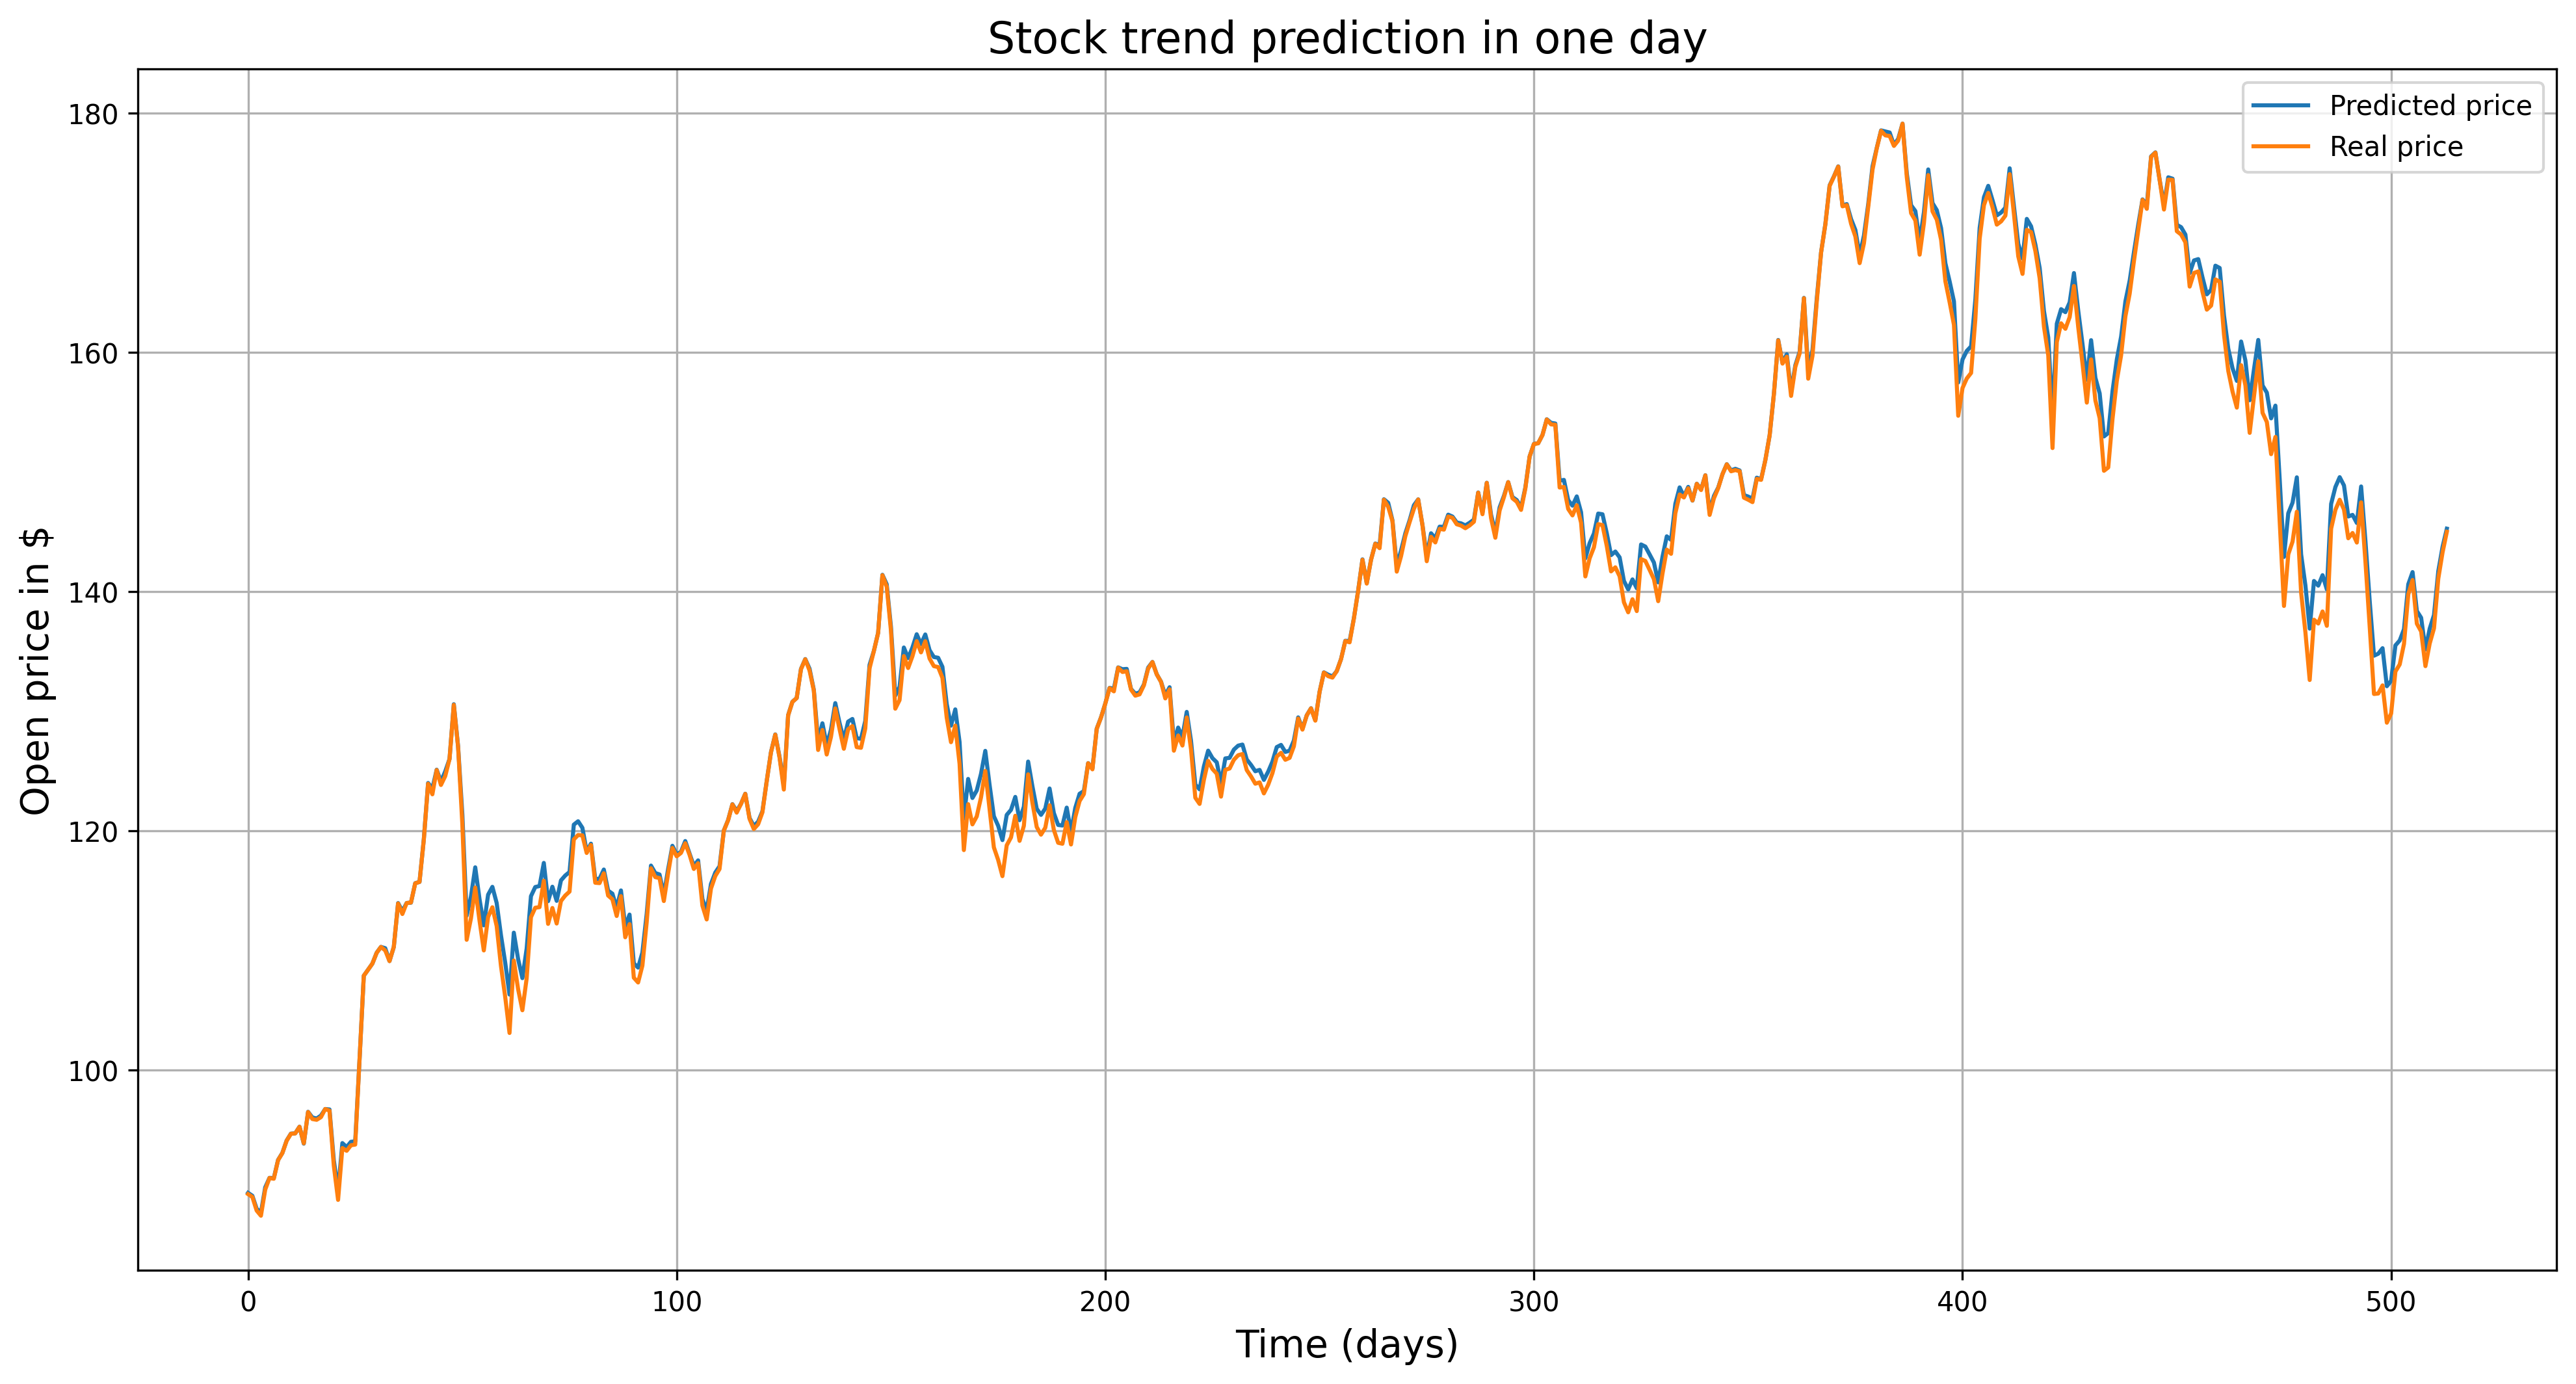

In [29]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

Zoom in to the prediction in the most recent 100 days

In [ ]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(openPred1[-100:], label='Predicted price')
plt.plot(y_test[-100:], label='Real price')
plt.title('Stock trend prediction in the last 100 days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### 7 day prediction

#### -- Train Test Set

In [30]:
df.columns[0]

'Open'

In [31]:
### TRAIN TEST SET SPLIT
"""
Input features (X):
- Window: 30 days of historical data
Labels (y):
- The stock price 1 day after the last day in each window
"""
import numpy as np

X_data = []
y_data = []
window_size = 30
prediction_days = 7

for i in range(len(df) - window_size - prediction_days +1):
    data_feature = []
    data_label = []
    
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 2])  # Assuming column index 2 is the open price
    
    # This ensures that the label corresponds to the stock price 7 days after the last day in each window.
    data_label.append(df.iloc[i + window_size + prediction_days - 1, 2])
    
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_test = X_test.shape[0]

# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

#### -- RNN

In [32]:
### RUN THE MODEL ON TRAIN AND TEST SET
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statistics

tscv = TimeSeriesSplit()
loss_result = []
count = 1
for train_index, val_index in tscv.split(X_train_norm):
    x_train, y_train = X_train_norm[train_index], y_train_norm[train_index]
    x_val, y_val = X_train_norm[val_index], y_train_norm[val_index]
    # Compile and train the model with Mean Squared Error loss function
    RNN_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='mse', 
                          metrics=['mse'])
    history = RNN_model.fit(X_train_norm, y_train_norm, validation_data=(x_val,y_val), epochs=100, batch_size=32)
    
    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    # Get prediction on the test data
    y_predict = RNN_model.predict(x_val)
    loss_result.append(mean_squared_error(y_val,y_predict))
    print("COMPLETE",count,'/5 FOLDS')
    count += 1

# Calculate the average evaluation metrics across all folds
print("AVERAGE MSE ACROSS ALL FOLDS: ", statistics.mean(loss_result))

Epoch 1/100
65/65 [==============================] - 3s 17ms/step - loss: 0.1989 - mse: 0.1989 - val_loss: 0.2526 - val_mse: 0.2526
Epoch 2/100
65/65 [==============================] - 0s 6ms/step - loss: 0.1976 - mse: 0.1976 - val_loss: 0.2523 - val_mse: 0.2523
Epoch 3/100
65/65 [==============================] - 0s 6ms/step - loss: 0.1985 - mse: 0.1985 - val_loss: 0.2516 - val_mse: 0.2516
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 0.1998 - mse: 0.1998 - val_loss: 0.2521 - val_mse: 0.2521
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 0.1978 - mse: 0.1978 - val_loss: 0.2546 - val_mse: 0.2546
Epoch 6/100
65/65 [==============================] - 0s 7ms/step - loss: 0.1986 - mse: 0.1986 - val_loss: 0.2595 - val_mse: 0.2595
Epoch 7/100
65/65 [==============================] - 0s 6ms/step - loss: 0.1968 - mse: 0.1968 - val_loss: 0.2558 - val_mse: 0.2558
Epoch 8/100
65/65 [==============================] - 0s 6ms/step - loss: 0.1982 - 

In [44]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm_30 = RNN_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

17/17 [==============================] - 0s 14ms/step
MSE on the test set:  0.2711378886740058


In [45]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm_30 = y_pred_norm_30
for i in range(0, len(y_pred_denorm_30)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm_30[i] = y_pred_norm_30[i] * (max_feature - min_feature) + min_feature

#### -- Visualizing the results

In [46]:
# Store predicted values
openPred = []
for val in y_pred_denorm_30:
  for i in val:
    openPred.append(i)
start_index = -len(openPred)
df['openPred7'] = pd.Series(openPred, index=df.index[len(df)-len(openPred):])
df.head(-10)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-03-12   19.606428   19.714287   19.535713   19.714287   16.756018   
2012-03-13   19.912144   20.292143   19.848213   20.289286   17.244738   
2012-03-14   20.644644   21.240000   20.549999   21.056429   17.896757   
2012-03-15   21.414642   21.428928   20.662500   20.912857   17.774731   
2012-03-16   20.882856   21.042856   20.642857   20.913214   17.775032   
...                ...         ...         ...         ...         ...   
2022-06-16  132.080002  132.389999  129.039993  130.059998  129.287994   
2022-06-17  130.070007  133.080002  129.809998  131.559998  130.779099   
2022-06-21  133.419998  137.059998  133.320007  135.869995  135.063492   
2022-06-22  134.789993  137.759995  133.910004  135.350006  134.546585   
2022-06-23  136.820007  138.589996  135.630005  138.270004  137.449249   

                Volume   openPred1   openPred7  
Date                                            
2012-03-12   407282400         NaN         NaN  
2012-03-13   690855200         NaN         NaN  
2012-03-14  1418844000         NaN         NaN  
2012-03-15  1159718000         NaN         NaN  
2012-03-16   825487600         NaN         NaN  
...                ...         ...         ...  
2022-06-16   108123900  132.088913  147.678680  
2022-06-17   134520300  132.546616  147.903320  
2022-06-21    81000500  135.501633  159.343643  
2022-06-22    73409200  135.913849  157.268723  
2022-06-23    72433800  136.857346  153.765030  

[2589 rows x 8 columns]

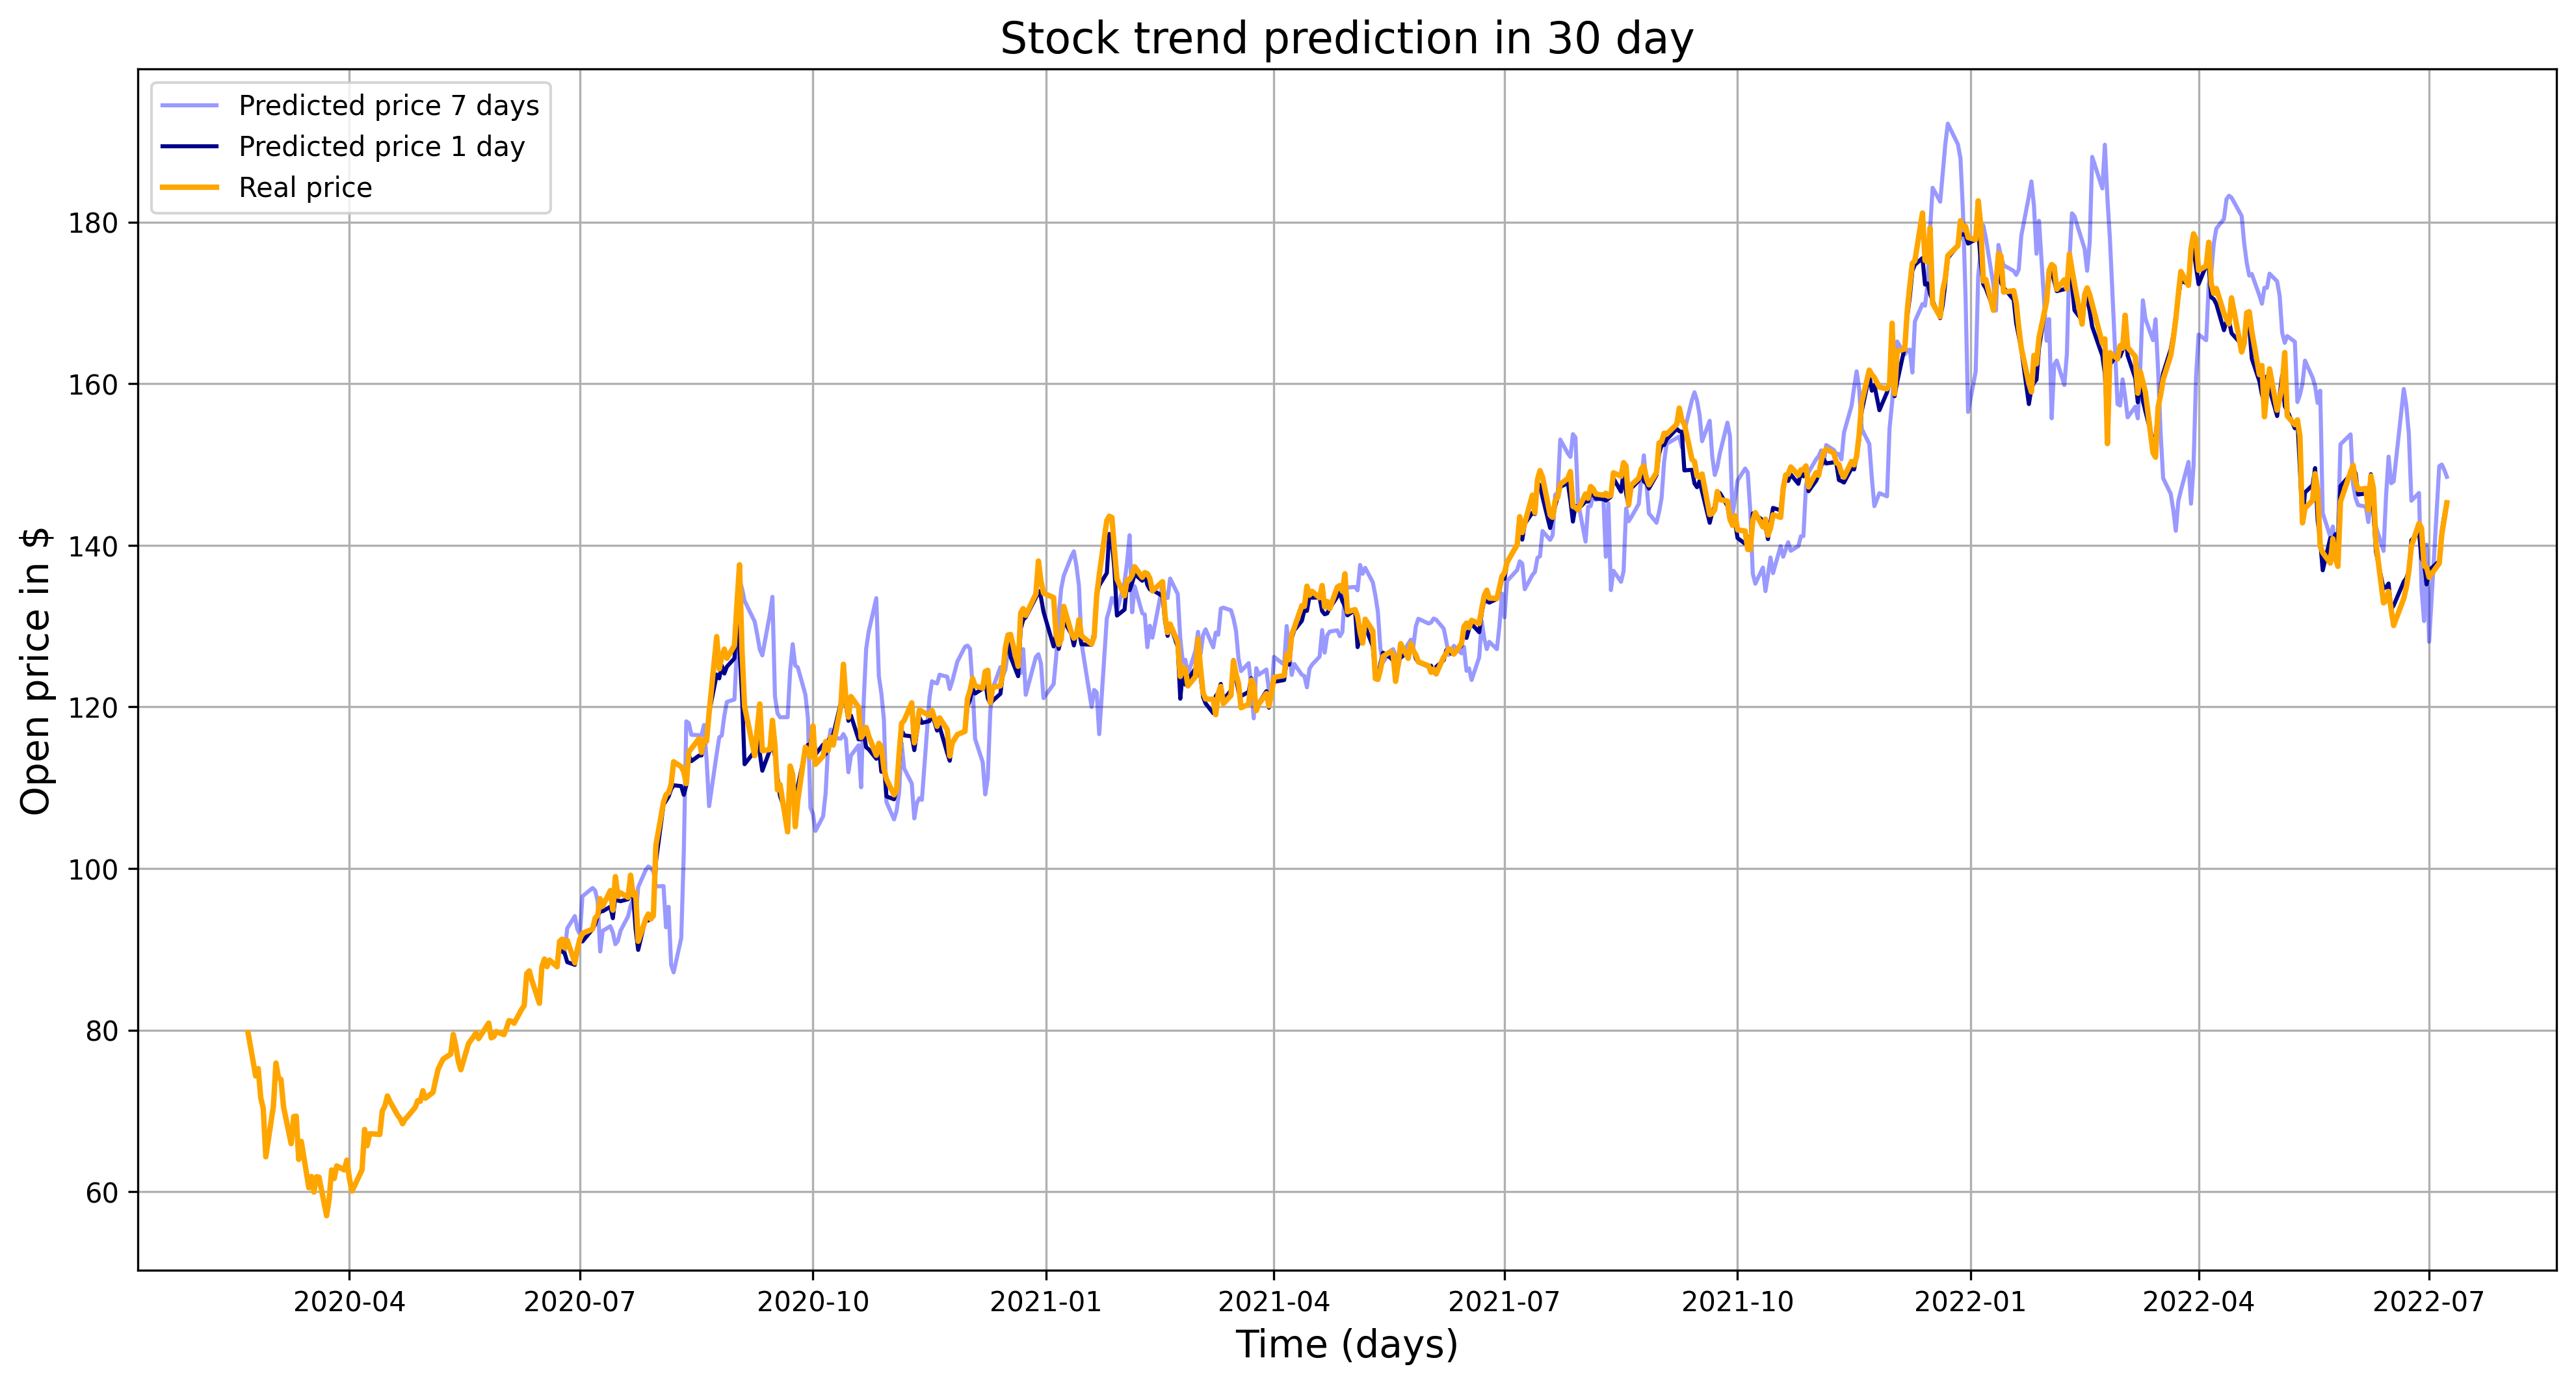

In [50]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(df['openPred7'][-600:], label='Predicted price 7 days', color='blue', alpha=0.4)
plt.plot(df['openPred1'][-600:], label='Predicted price 1 day', color='darkblue')
plt.plot(df['Open'][-600:], label='Real price', linewidth=2, color ='orange')
#plt.plot(ema[-600:], label='EMA', color ='red')
plt.title('Apple Adj. Stock Trend Prediction', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

Zoom in to the prediction in the most recent 100 days

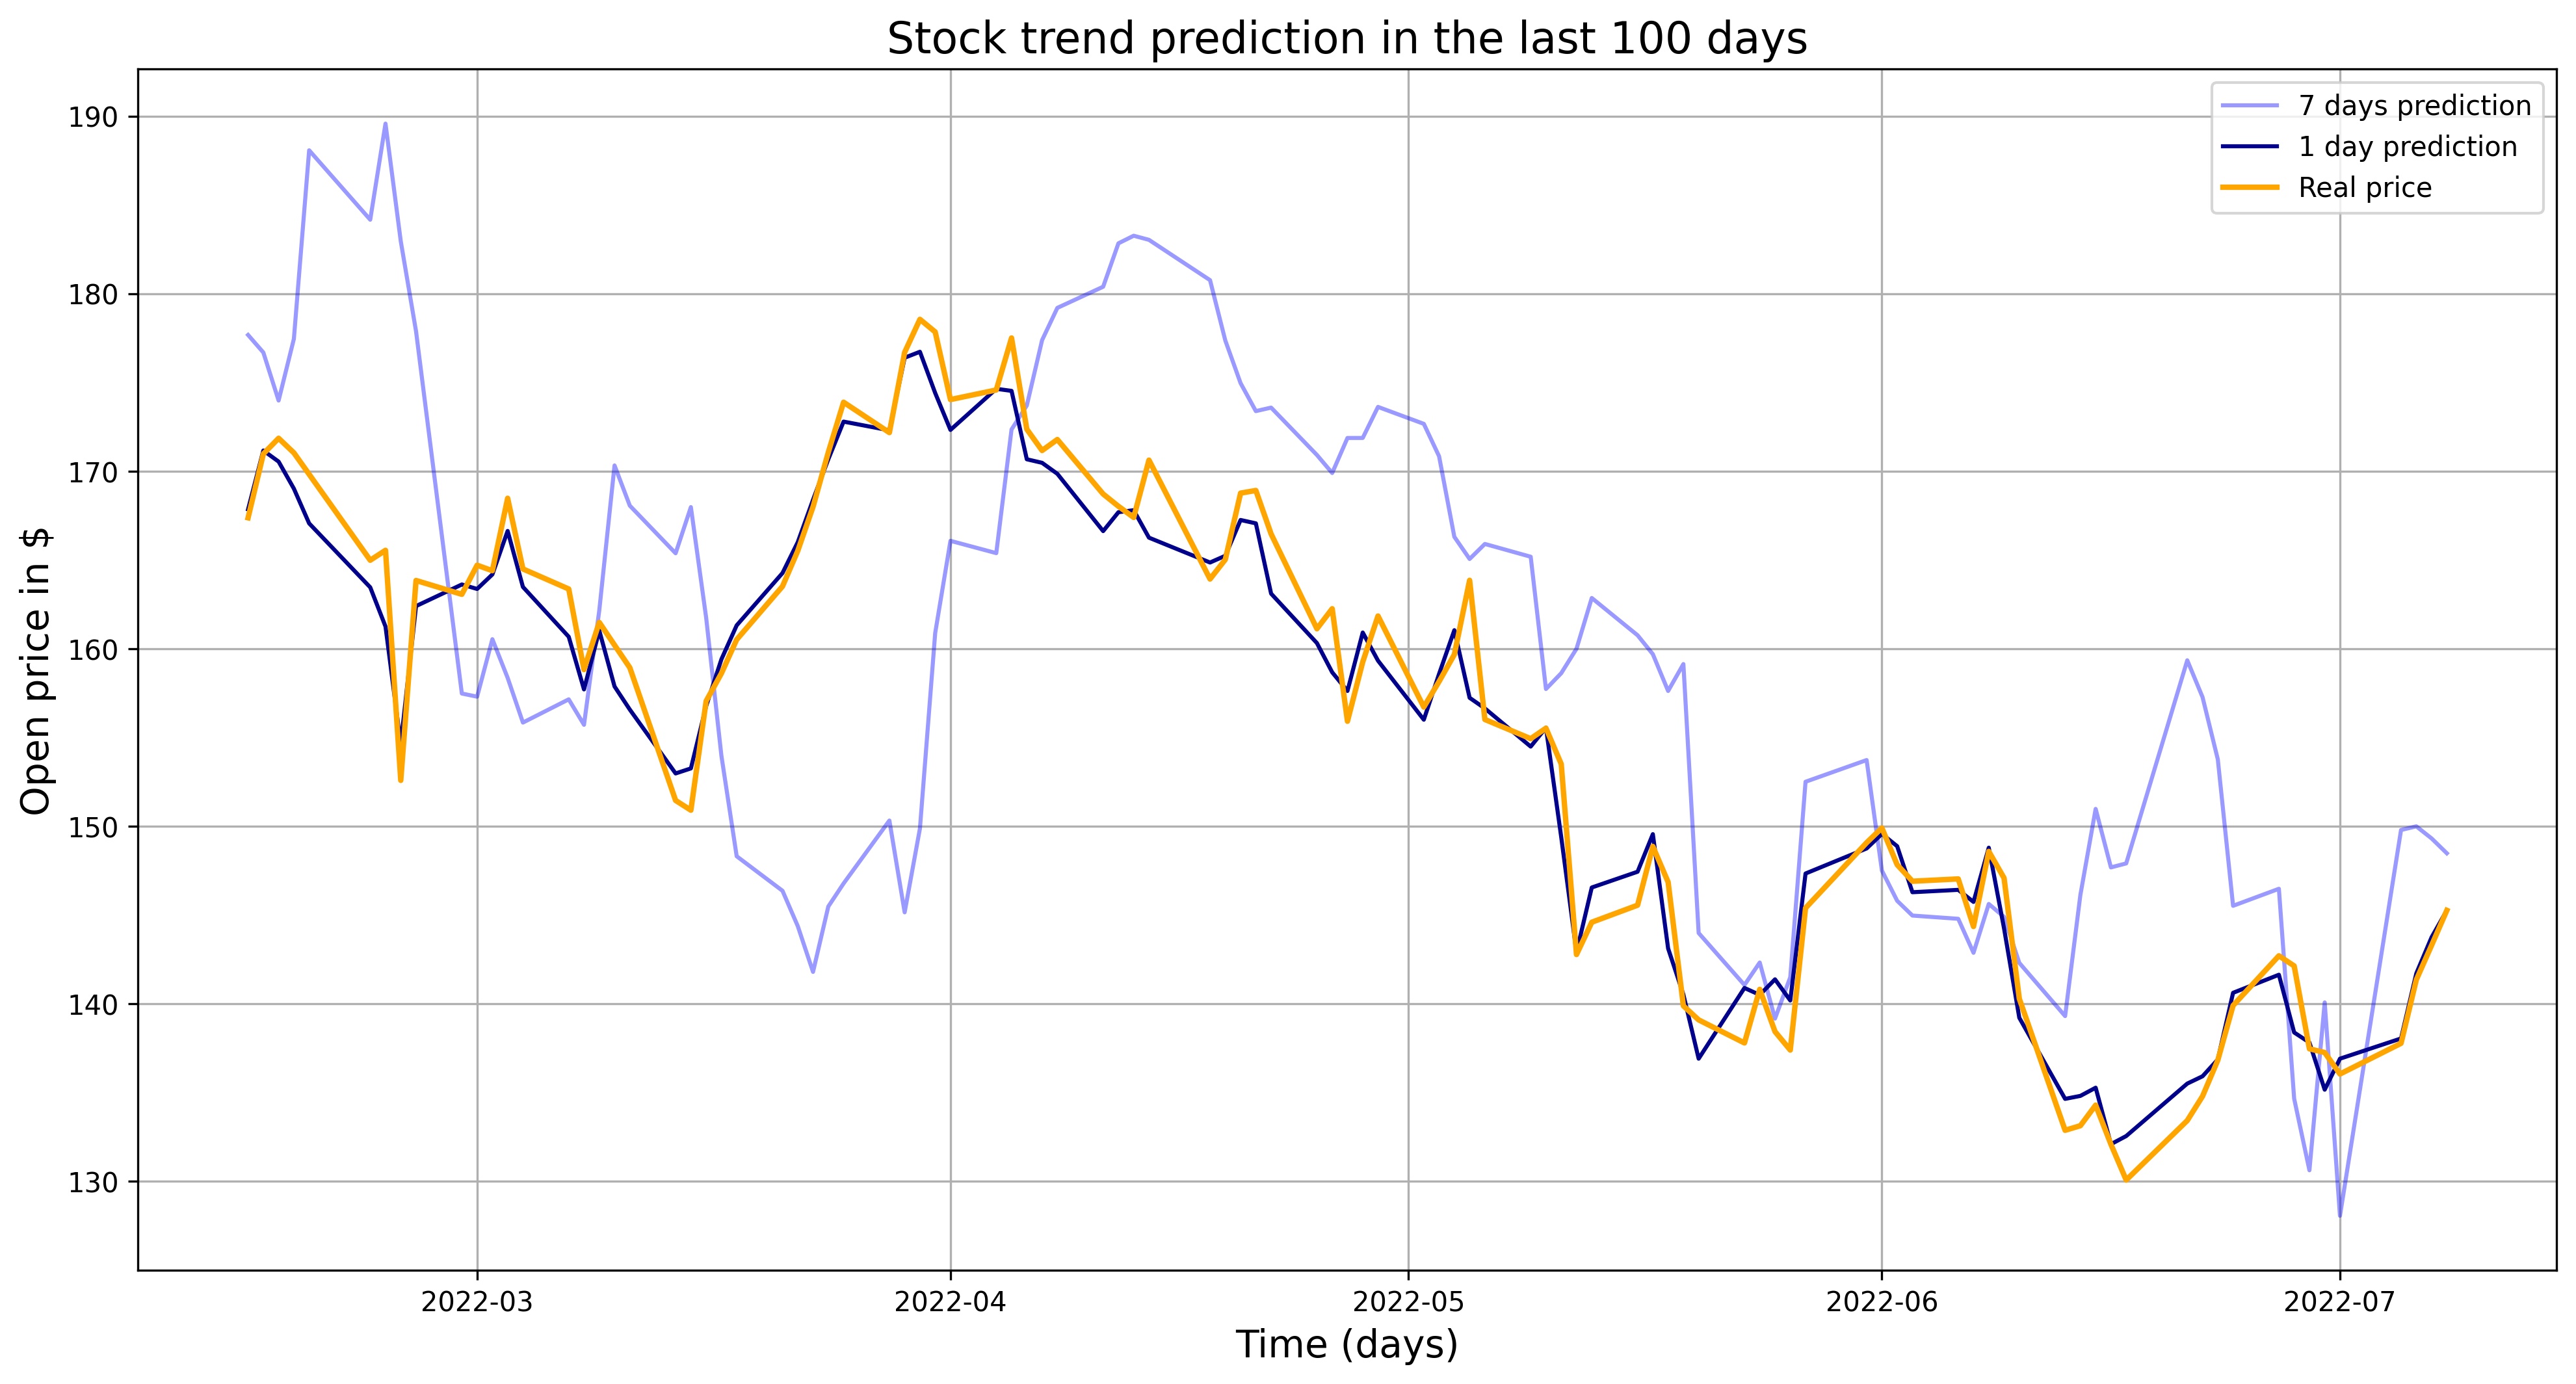

In [51]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(df['openPred7'][-100:], label='7 days prediction', color='blue', alpha=0.4)
plt.plot(df['openPred1'][-100:], label='1 day prediction', color='darkblue')
plt.plot(df['Open'][-100:], label='Real price', linewidth=2, color ='orange')
plt.title('Stock trend prediction in the last 100 days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# 🎯 **Trading Points generated from predicted values and EMA**

In [58]:
def buySell(ACBdf2, time_range):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1
    prev_signal_time = None
    for i in range(len(ACBdf2)):
        if ACBdf2['openPred'][i] > ACBdf2['EMA'][i]:
            if flag != 1:
                if prev_signal_time is None or (ACBdf2.index[i] - prev_signal_time).days > time_range:
                    sigPriceBuy.append(ACBdf2['Open'][i])
                    sigPriceSell.append(np.nan)
                    flag = 1
                    prev_signal_time = ACBdf2.index[i]
                else:
                    sigPriceBuy.append(np.nan)
                    sigPriceSell.append(np.nan)
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif ACBdf2['openPred'][i] < ACBdf2['EMA'][i]:
            if flag != 0:
                if prev_signal_time is None or (ACBdf2.index[i] - prev_signal_time).days > time_range:
                    sigPriceBuy.append(np.nan)
                    sigPriceSell.append(ACBdf2['Open'][i])
                    flag = 0
                    prev_signal_time = ACBdf2.index[i]
                else:
                    sigPriceBuy.append(np.nan)
                    sigPriceSell.append(np.nan)
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return sigPriceBuy, sigPriceSell

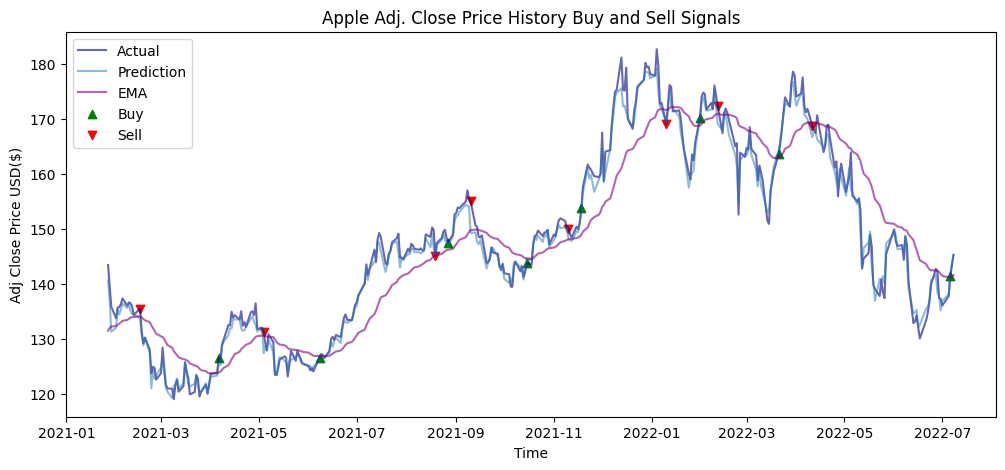

In [59]:
period = 30  # EMA period
ema = calculate_ema(df['Open'], period)
df['EMA'] = ema
#=======================
df2 = pd.DataFrame()
df2["Open"]=df["Open"]
df2['EMA']=df['EMA']
df2['openPred']=df['openPred1']  # Use the 1 day prediction for the closest estimation to the actual price

time_range = 7  # Time range in days (eliminate signals that are too closed to each other e.g. within 7 days trade)

buySellSignals = buySell(df2, time_range)
df2['Buy Signal Price'] = buySellSignals[0]
df2['Sell Signal Price'] = buySellSignals[1]
# df2.head(-10)

plt.figure(figsize=(12,5))
plt.plot(df2['Open'][-365:], label='Actual', alpha=0.6, color='darkblue')
plt.plot(df2['openPred'][-365:],label='Prediction', alpha=0.5)
plt.plot(df2['EMA'][-365:], label='EMA', alpha=0.6, color='purple')
plt.scatter(df.index[-365:], df2['Buy Signal Price'][-365:], label ='Buy', marker='^',color='green')
plt.scatter(df.index[-365:], df2['Sell Signal Price'][-365:],label='Sell', marker='v', color='red')
plt.title('Apple Adj. Open Price History Buy and Sell Signals')
plt.xlabel("Time")
plt.ylabel("Adj Close Price USD($)")
plt.legend(loc='upper left')
plt.savefig('RNN Prediction against EMA.png')
plt.show()

### Trading Points generated from simple moving average (SMA)

This is for comparison with the above approach that uses LSTM predicted value and EMA

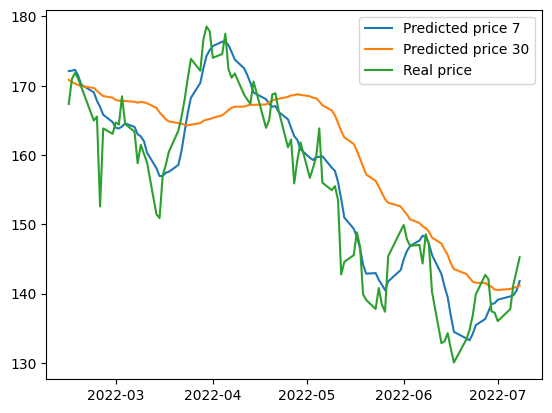

In [269]:
plt.plot(df['Moving Average 07 days'][-100:], label='Predicted price 7')
plt.plot(df['Moving Average 30 days'][-100:], label='Predicted price 30')
plt.plot(df['Open'][-100:], label='Real price'); plt.legend() # Add legend

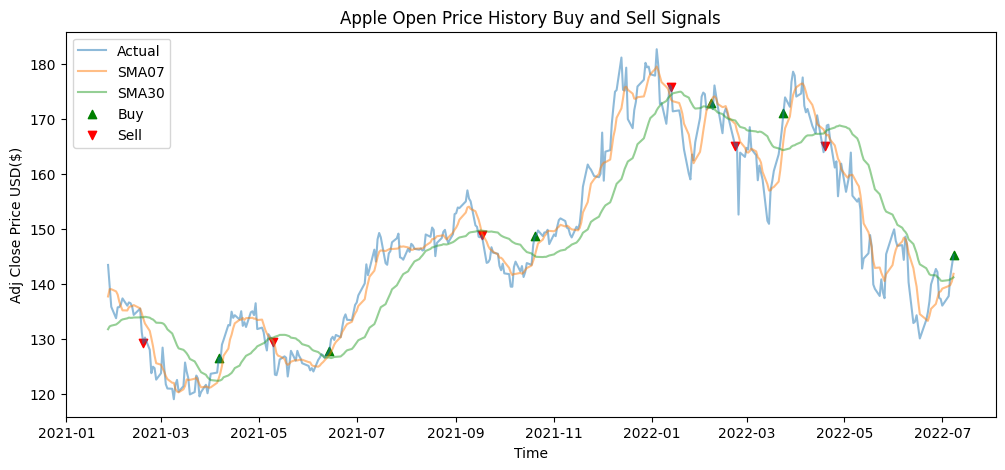

In [271]:
df2 = pd.DataFrame()
df2["apple"]=df["Open"]
df2['SMA07']=df['Moving Average 07 days']
df2['SMA30']=df['Moving Average 30 days']
def buySell(df2):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1
    for i in range(len(df2)):
        if df2 ['SMA07'][i] > df2['SMA30'][i]:
            if flag != 1:
                sigPriceBuy.append(df2['apple'][i])
                sigPriceSell.append(np.nan)
                flag = 1
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif df2['SMA07'][i] < df2['SMA30'][i]:
            if flag != 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(df2['apple'][i])
                flag = 0
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        else:
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return(sigPriceBuy, sigPriceSell)


buySell=buySell(df2)
df2['Buy Signal Price'] = buySell[0]
df2['Sell Signal Price'] = buySell[1]
# df2.head(-10)

plt.figure(figsize=(12,5))
plt.plot(df2['apple'][-365:], label='Actual', alpha=0.5)
plt.plot(df2['SMA07'][-365:], label='SMA07', alpha=0.5)
plt.plot(df2['SMA30'][-365:],label='SMA30', alpha=0.5)
plt.scatter(df.index[-365:], df2['Buy Signal Price'][-365:], label ='Buy', marker='^',color='green')
plt.scatter(df.index[-365:], df2['Sell Signal Price'][-365:],label='Sell', marker='v', color='red')
plt.title('Apple Open Price History Buy and Sell Signals')
plt.xlabel("Time")
plt.ylabel("Adj Close Price USD($)")
plt.legend(loc='upper left')
plt.show()

# VNIndex: Ngân hàng Á Châu ACB

### Load files

In [60]:
file_path = 'D:\Final-project-stock-FUV\data-vn-20230228\data-vn-20230228\stock-historical-data\ACB-VNINDEX-History.csv'
vndf = pd.read_csv(file_path)
vndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4052 non-null   int64  
 1   Open         4052 non-null   float64
 2   High         4052 non-null   float64
 3   Low          4052 non-null   float64
 4   Close        4052 non-null   float64
 5   Volume       4052 non-null   int64  
 6   TradingDate  4052 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 221.7+ KB


In [61]:
print("Starting date: ",vndf.iloc[0][-1])
print("Ending date: ",vndf.iloc[-1][-1])

Starting date:  2006-11-21
Ending date:  2023-02-28


### 1 day window size

#### -- Train Test Set

In [62]:
vndf.columns[1]

'Open'

In [63]:
"""
Input features (X):
- Window: 30 days of historical data
Labels (y):
- The stock price 1 day after the last day in each window
"""
import numpy as np

X_data = []
y_data = []
window_size = 30
prediction_days = 0

for i in range(len(vndf) - window_size - prediction_days +1):
    data_feature = []
    data_label = []
    
    for j in range(window_size):
        data_feature.append(vndf.iloc[i + j, 2])  # Assuming column index 2 is the open price
    
    # This ensures that the label corresponds to the stock price 7 days after the last day in each window.
    data_label.append(vndf.iloc[i + window_size + prediction_days - 1, 2])
    
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Visualize the training, validation and test set
vndf_plot = vndf['Open']
vndf_plot = vndf_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_test = X_test.shape[0]

# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

#### -- RNN Model

##### -- Start running the model

In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statistics

tscv = TimeSeriesSplit()
loss_result = []
count = 1
for train_index, val_index in tscv.split(X_train_norm):
    x_train, y_train = X_train_norm[train_index], y_train_norm[train_index]
    x_val, y_val = X_train_norm[val_index], y_train_norm[val_index]
    # Compile and train the model with Mean Squared Error loss function
    RNN_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='mse', 
                          metrics=['mse'])
    history = RNN_model.fit(X_train_norm, y_train_norm, validation_data=(x_val,y_val), epochs=100, batch_size=32)
    
    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    # Get prediction on the test data
    y_predict = RNN_model.predict(x_val)
    loss_result.append(mean_squared_error(y_val,y_predict))
    
    print("COMPLETE",count,'/5 FOLDS')
    count += 1

# Calculate the average evaluation metrics across all folds
print("AVERAGE MSE ACROSS ALL FOLDS: ", statistics.mean(loss_result))

Epoch 1/100
101/101 [==============================] - 3s 12ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 7/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 8/100
101/101 [==============================] - 1s 6ms/step -

In [65]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = RNN_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

26/26 [==============================] - 0s 7ms/step
MSE on the test set:  0.0016302128441067893


In [66]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

##### -- Visualizing the results

In [67]:
# Create a function to signal when to buy or sell stock
openPred = []
for val in y_pred_denorm:
  for i in val:
    openPred.append(i)
start_index = len(openPred)
vndf['openPred'] = pd.Series(openPred, index=vndf.index[len(vndf)-len(openPred):])
vndf.head(-10)

Unnamed: 0     Open     High      Low    Close   Volume TradingDate  \
0              0   5050.0   8234.0   6532.0   7147.0    56500  2006-11-21   
1              1   6038.0   7861.0   7136.0   7394.0    62300  2006-11-22   
2              2   6093.0   7959.0   7136.0   7597.0    69900  2006-11-23   
3              3   5928.0   8344.0   7685.0   8058.0    63600  2006-11-24   
4              4   6203.0   8860.0   7410.0   8058.0    42400  2006-11-27   
...          ...      ...      ...      ...      ...      ...         ...   
4037        4037  24800.0  25050.0  24550.0  24650.0  1924125  2023-02-08   
4038        4038  24650.0  25100.0  24500.0  24500.0  3227424  2023-02-09   
4039        4039  24600.0  24750.0  24200.0  24200.0  2009129  2023-02-10   
4040        4040  24150.0  24150.0  23800.0  23900.0  2593039  2023-02-13   
4041        4041  24100.0  24100.0  23800.0  23850.0  1439656  2023-02-14   

          openPred  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
4037  25098.025391  
4038  25150.859375  
4039  24829.873047  
4040  24285.652344  
4041  24232.820312  

[4042 rows x 8 columns]

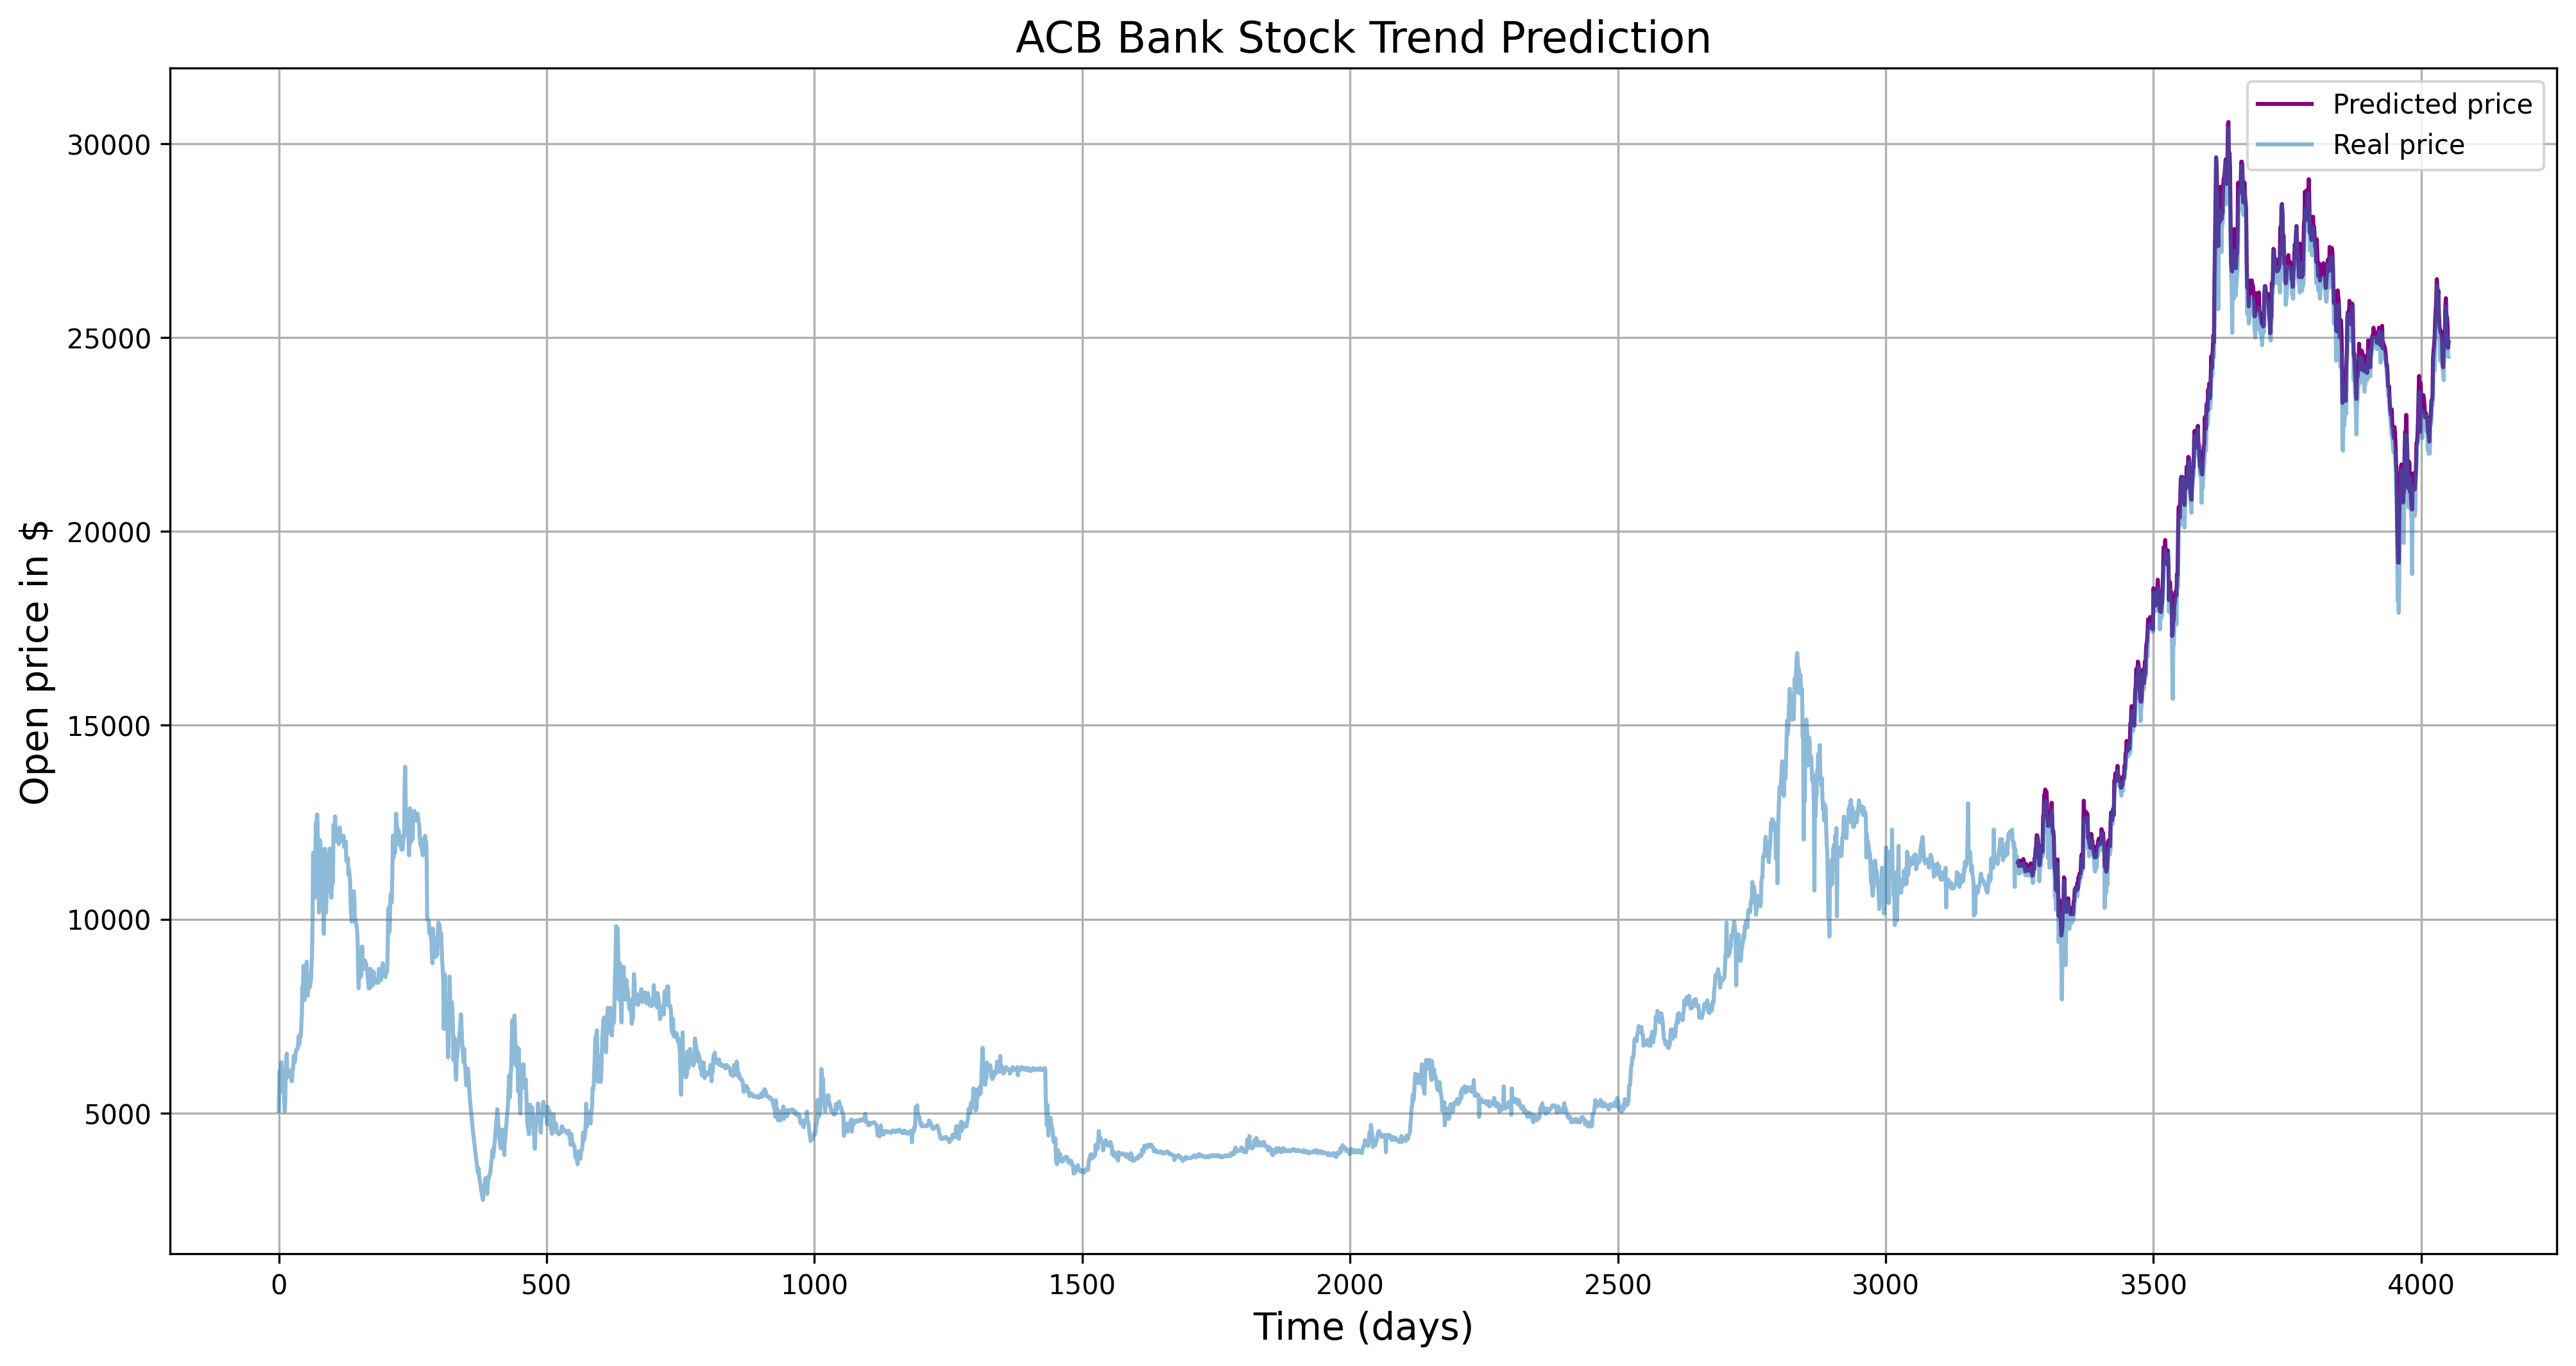

In [69]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['openPred'], label='Predicted price',color='purple')
plt.plot(vndf['Open'], label='Real price',alpha=0.5)
plt.title('ACB Bank Stock Trend Prediction', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

Zoom in to the prediction in the most recent 100 days

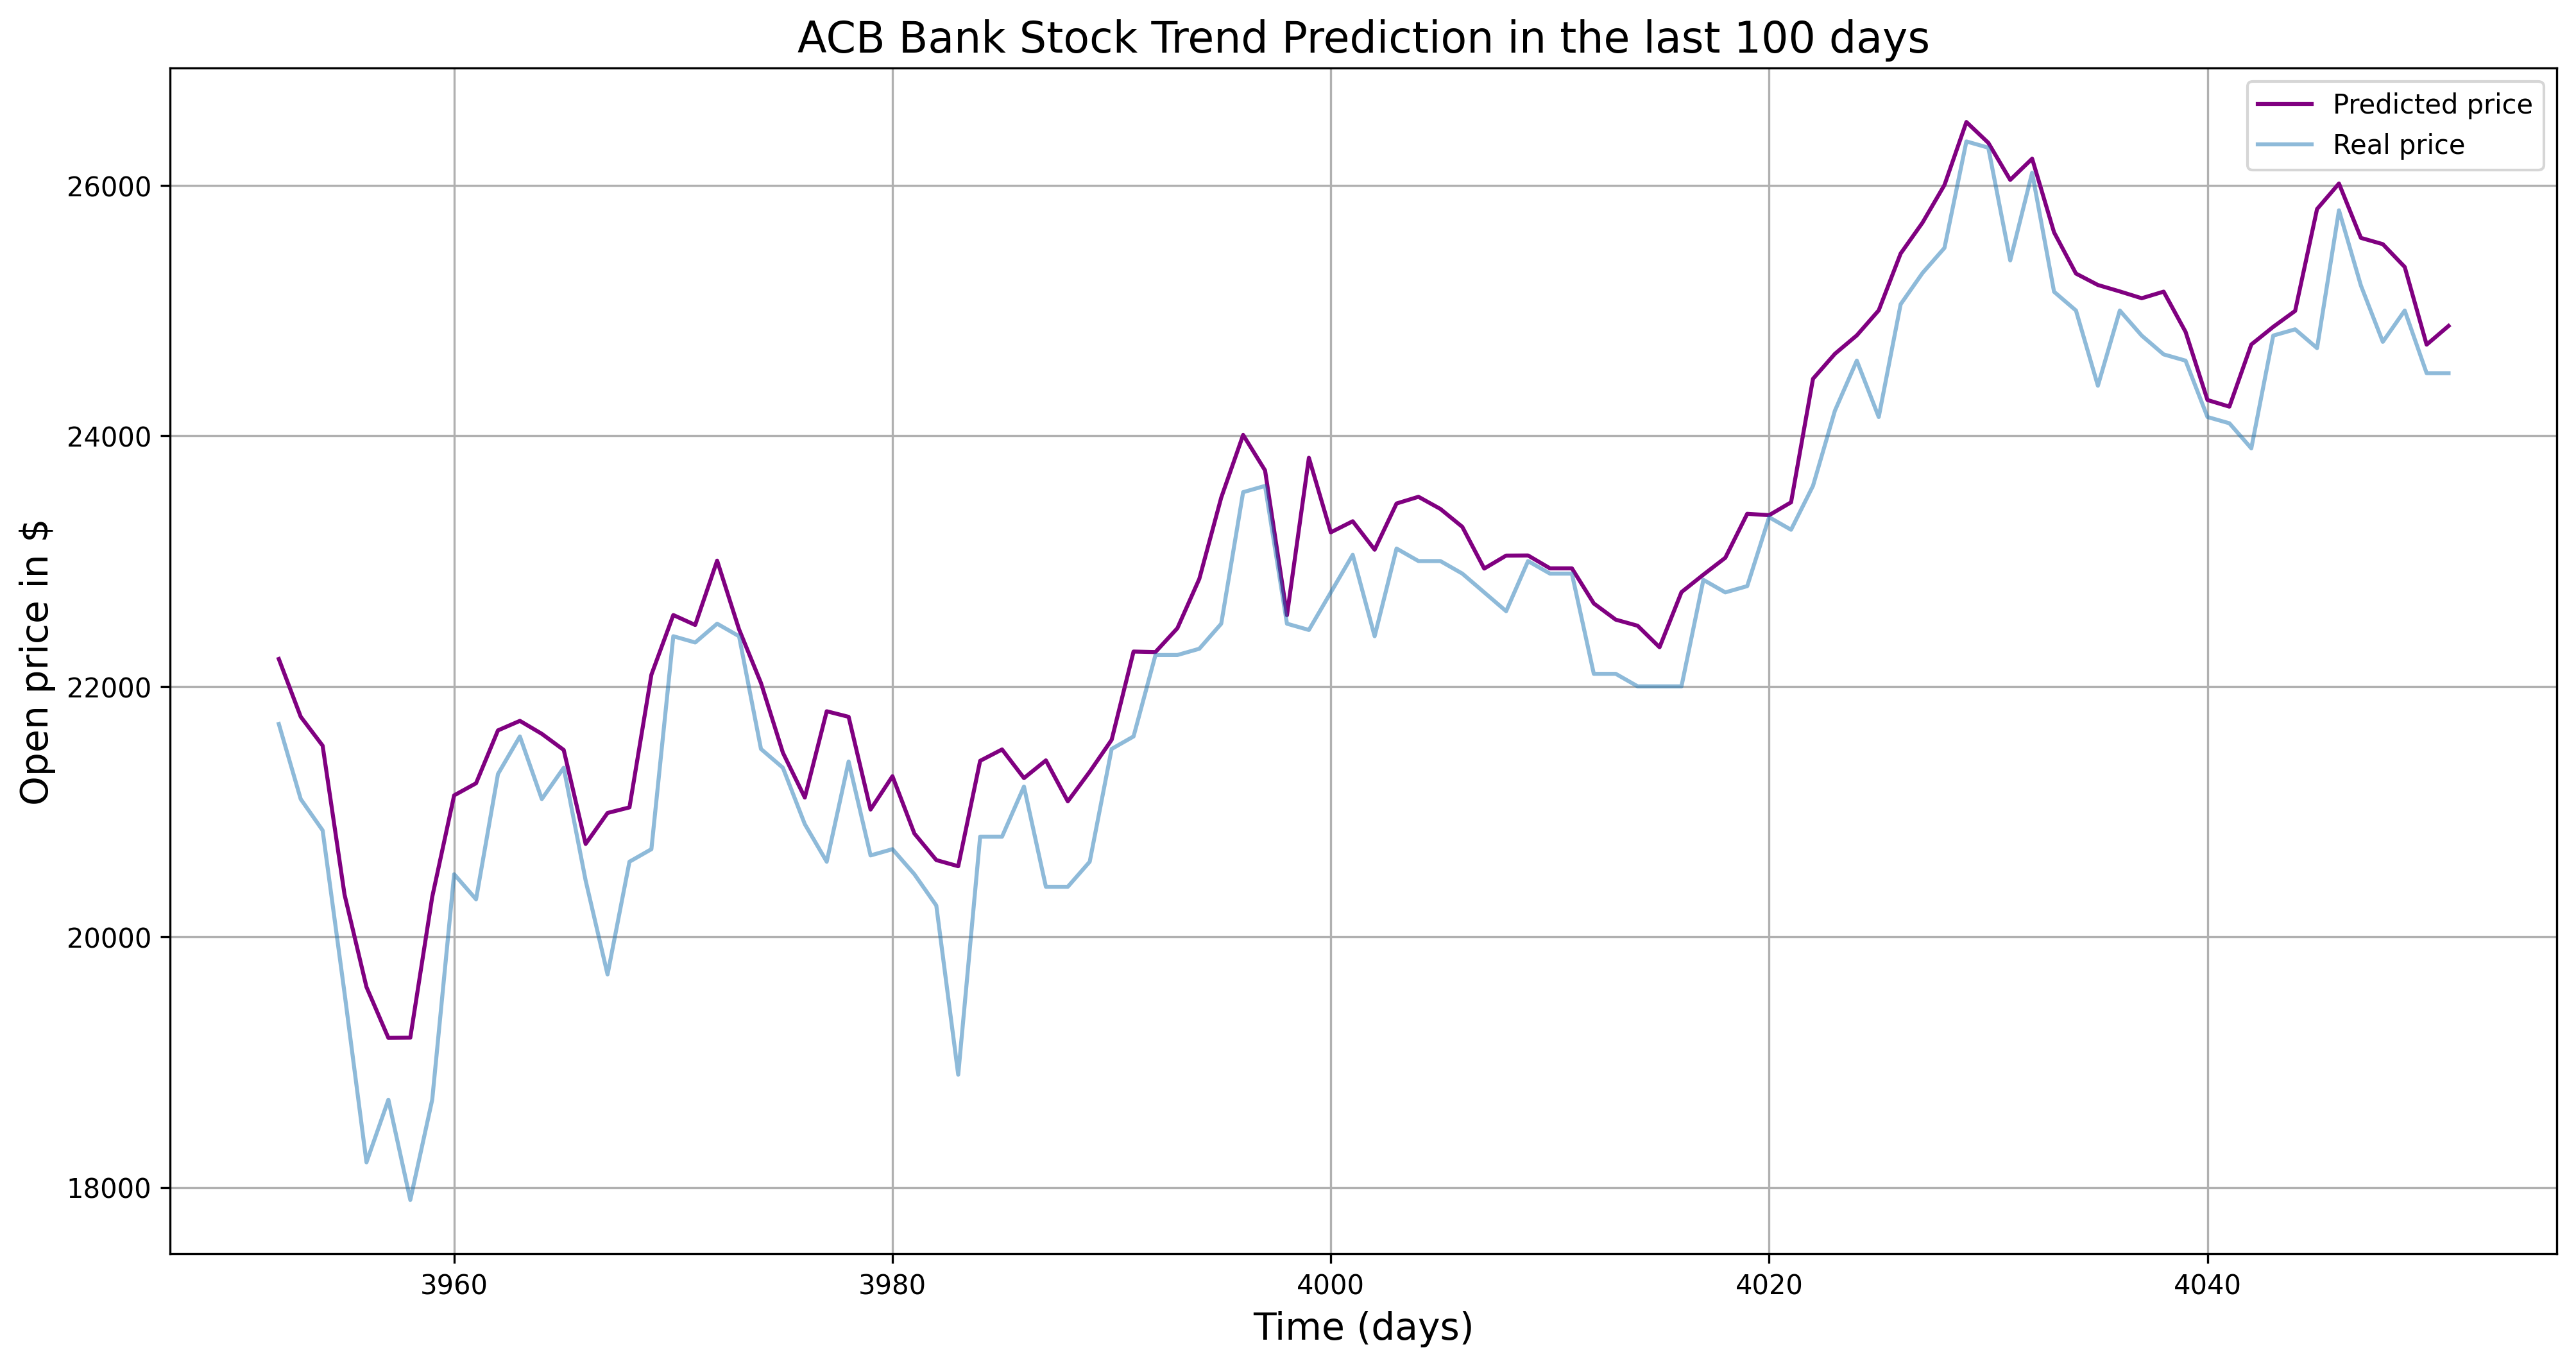

In [70]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['openPred'][-100:], label='Predicted price',color='purple')
plt.plot(vndf['Open'][-100:], label='Real price',alpha=0.5)
plt.title('ACB Bank Stock Trend Prediction in the last 100 days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

#### -- GRU

In [71]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, GRU

GRU_model=Sequential()
GRU_model.add(GRU(32,return_sequences=True,input_shape=(window_size,1)))
GRU_model.add(GRU(32,return_sequences=True))
GRU_model.add(GRU(32))
GRU_model.add(Dropout(0.20))
GRU_model.add(Dense(1))
GRU_model.compile(loss='mean_squared_error',optimizer='adam')

GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 30, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


##### -- Start running the model

In [72]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statistics

tscv = TimeSeriesSplit()
loss_result = []
count = 1
for train_index, val_index in tscv.split(X_train_norm):
    x_train, y_train = X_train_norm[train_index], y_train_norm[train_index]
    x_val, y_val = X_train_norm[val_index], y_train_norm[val_index]
    # Compile and train the model with Mean Squared Error loss function
    GRU_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='mse', 
                          metrics=['mse'])
    history = GRU_model.fit(X_train_norm, y_train_norm, validation_data=(x_val,y_val), epochs=100, batch_size=32)
    
    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    # Get prediction on the test data
    y_predict = GRU_model.predict(x_val)
    loss_result.append(mean_squared_error(y_val,y_predict))
    
    print("COMPLETE",count,'/5 FOLDS')
    count += 1

# Calculate the average evaluation metrics across all folds
print("AVERAGE MSE ACROSS ALL FOLDS: ", statistics.mean(loss_result))

Epoch 1/100
101/101 [==============================] - 4s 14ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 2/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 3/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 7.1138e-04 - val_mse: 7.1138e-04
Epoch 5/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 5.6420e-04 - val_mse: 5.6420e-04
Epoch 6/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 3.5370e-04 - val_mse: 3.5370e-04
Epoch 7/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 2.7695e-04 - val_mse: 2.7695e-04
Epoch 8/100
101/101 [===============

In [83]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

26/26 [==============================] - 0s 10ms/step
MSE on the test set:  8.1905252812876e-05


In [84]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

##### -- Visualizing the results

In [85]:
# Create a function to signal when to buy or sell stock
openPred = []
for val in y_pred_denorm:
  for i in val:
    openPred.append(i)
start_index = len(openPred)
vndf['GRUOpenPred'] = pd.Series(openPred, index=vndf.index[len(vndf)-len(openPred):])
vndf.head(-10)

Unnamed: 0     Open     High      Low    Close   Volume TradingDate  \
0              0   5050.0   8234.0   6532.0   7147.0    56500  2006-11-21   
1              1   6038.0   7861.0   7136.0   7394.0    62300  2006-11-22   
2              2   6093.0   7959.0   7136.0   7597.0    69900  2006-11-23   
3              3   5928.0   8344.0   7685.0   8058.0    63600  2006-11-24   
4              4   6203.0   8860.0   7410.0   8058.0    42400  2006-11-27   
...          ...      ...      ...      ...      ...      ...         ...   
4037        4037  24800.0  25050.0  24550.0  24650.0  1924125  2023-02-08   
4038        4038  24650.0  25100.0  24500.0  24500.0  3227424  2023-02-09   
4039        4039  24600.0  24750.0  24200.0  24200.0  2009129  2023-02-10   
4040        4040  24150.0  24150.0  23800.0  23900.0  2593039  2023-02-13   
4041        4041  24100.0  24100.0  23800.0  23850.0  1439656  2023-02-14   

          openPred  GRUOpenPred01   GRUOpenPred  
0              NaN            NaN           NaN  
1              NaN            NaN           NaN  
2              NaN            NaN           NaN  
3              NaN            NaN           NaN  
4              NaN            NaN           NaN  
...            ...            ...           ...  
4037  25098.025391   25029.552734  25029.552734  
4038  25150.859375   25079.628906  25079.628906  
4039  24829.873047   24733.236328  24733.236328  
4040  24285.652344   24141.179688  24141.179688  
4041  24232.820312   24094.044922  24094.044922  

[4042 rows x 10 columns]

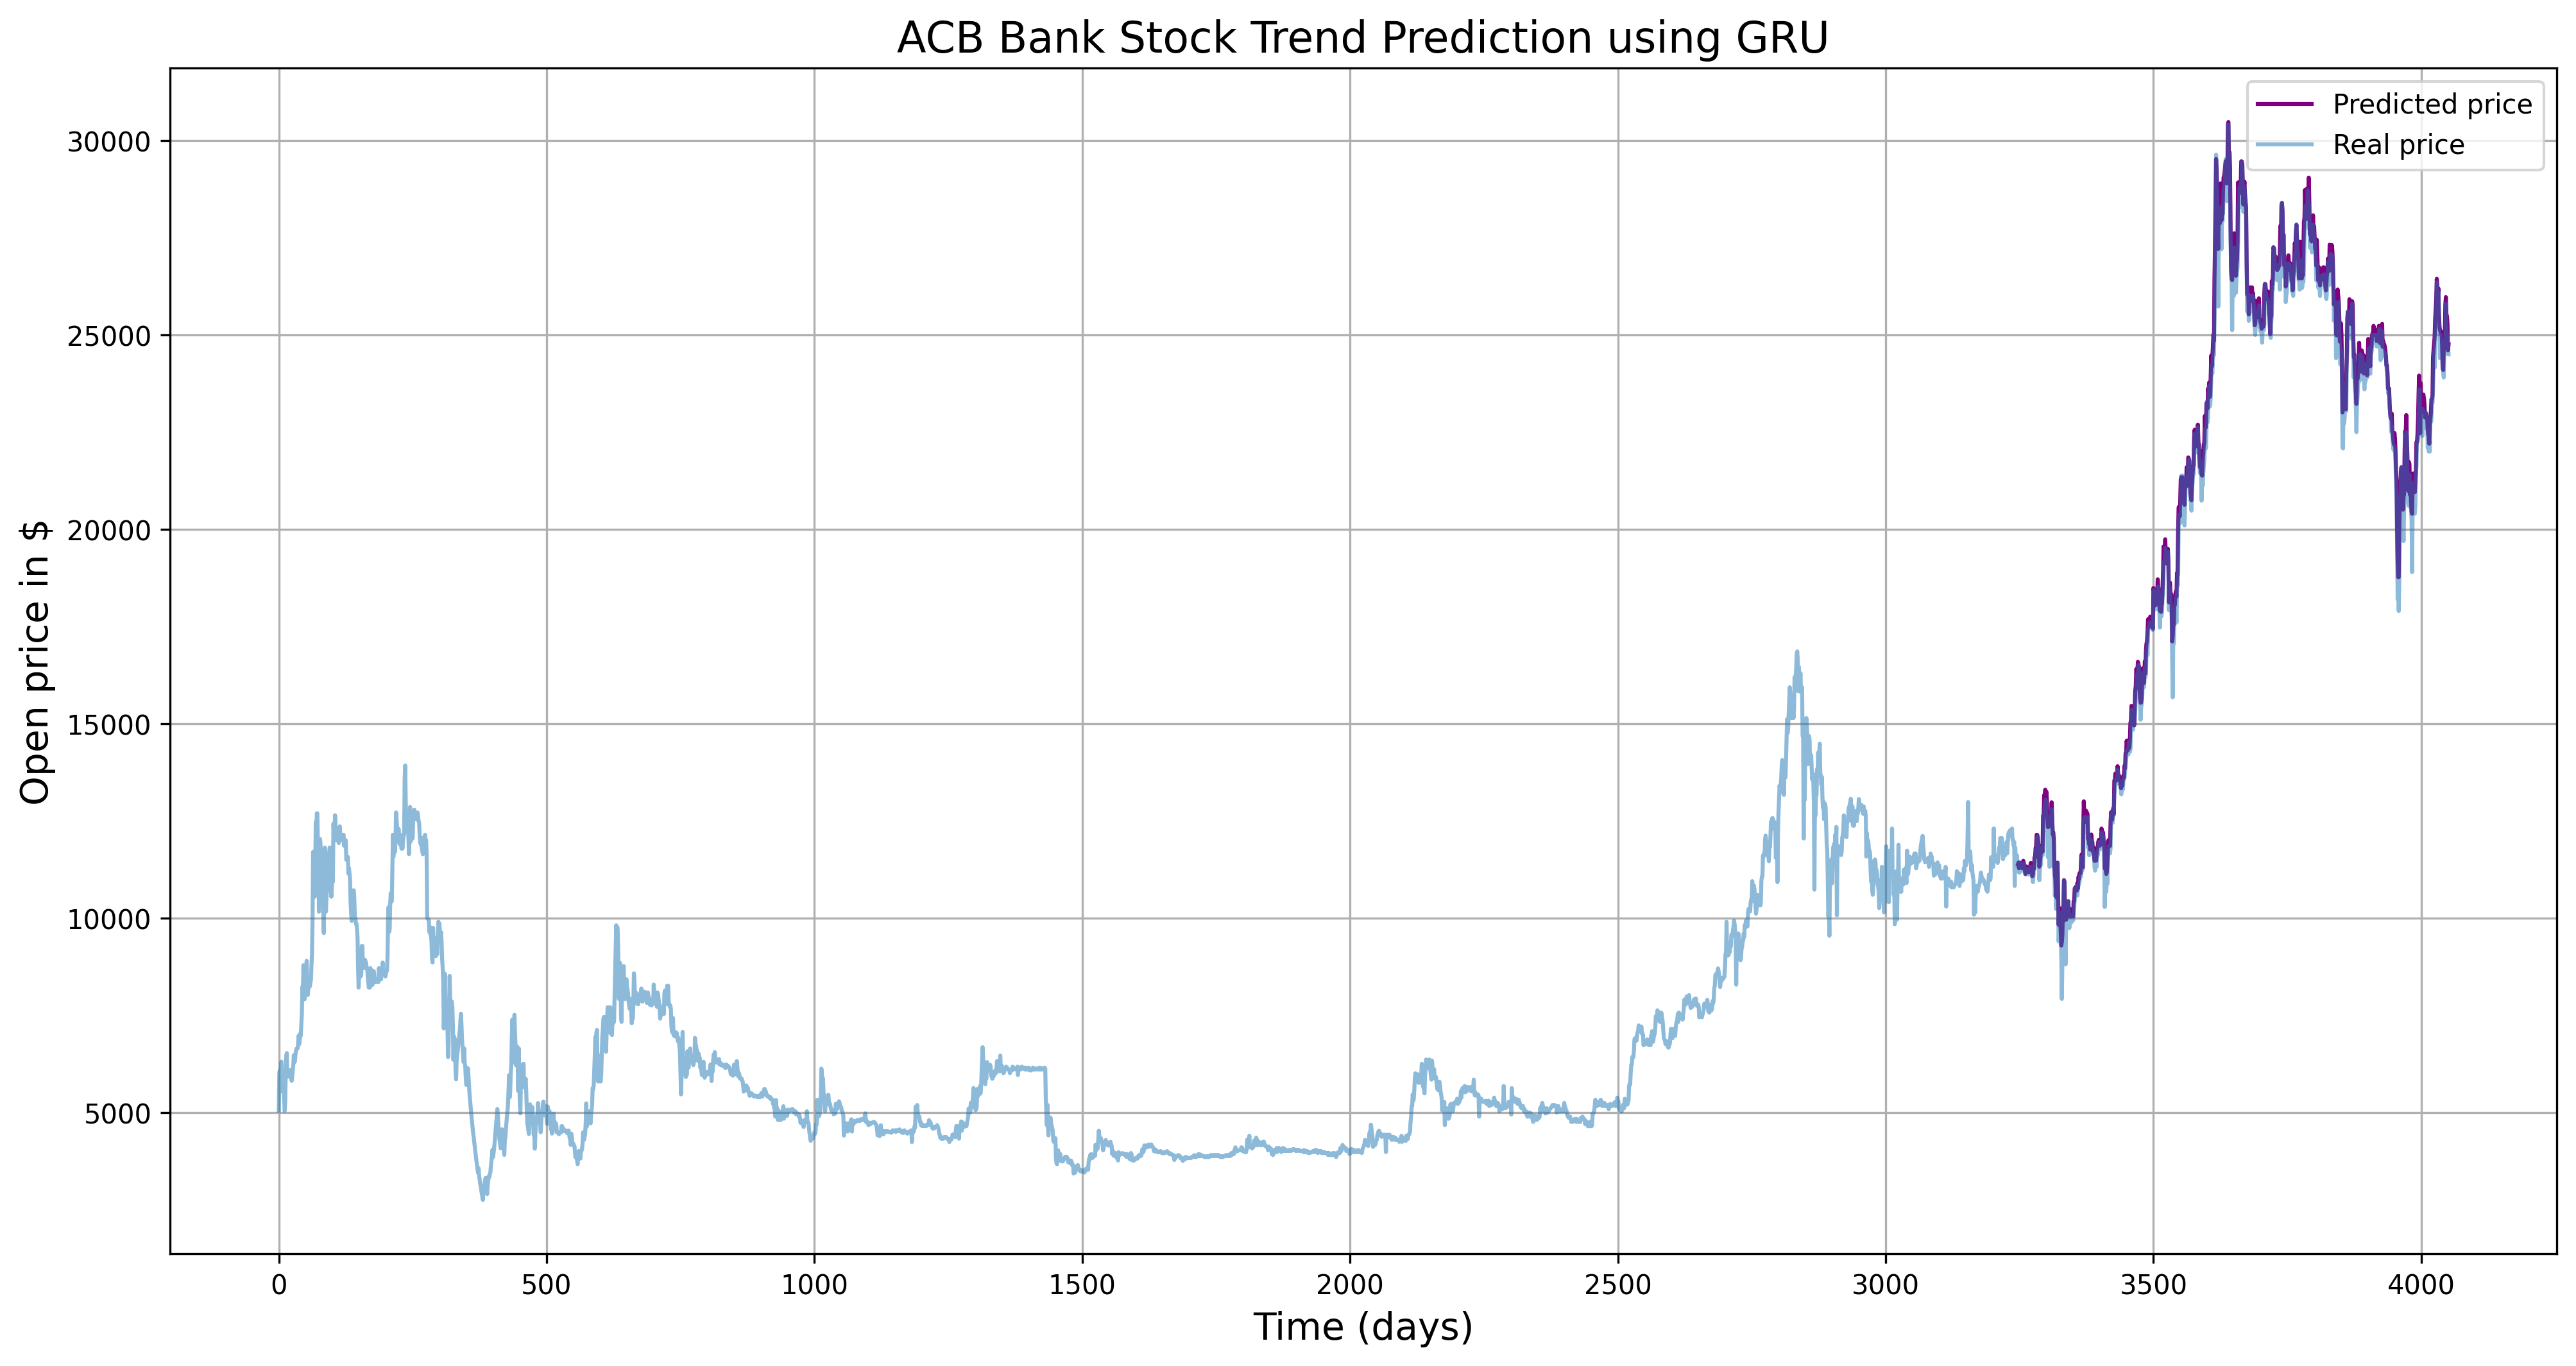

In [86]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['GRUOpenPred01'], label='Predicted price',color='purple')
plt.plot(vndf['Open'], label='Real price',alpha=0.5)
plt.title('ACB Bank Stock Trend Prediction using GRU', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

Zoom in to the prediction in the most recent 100 days

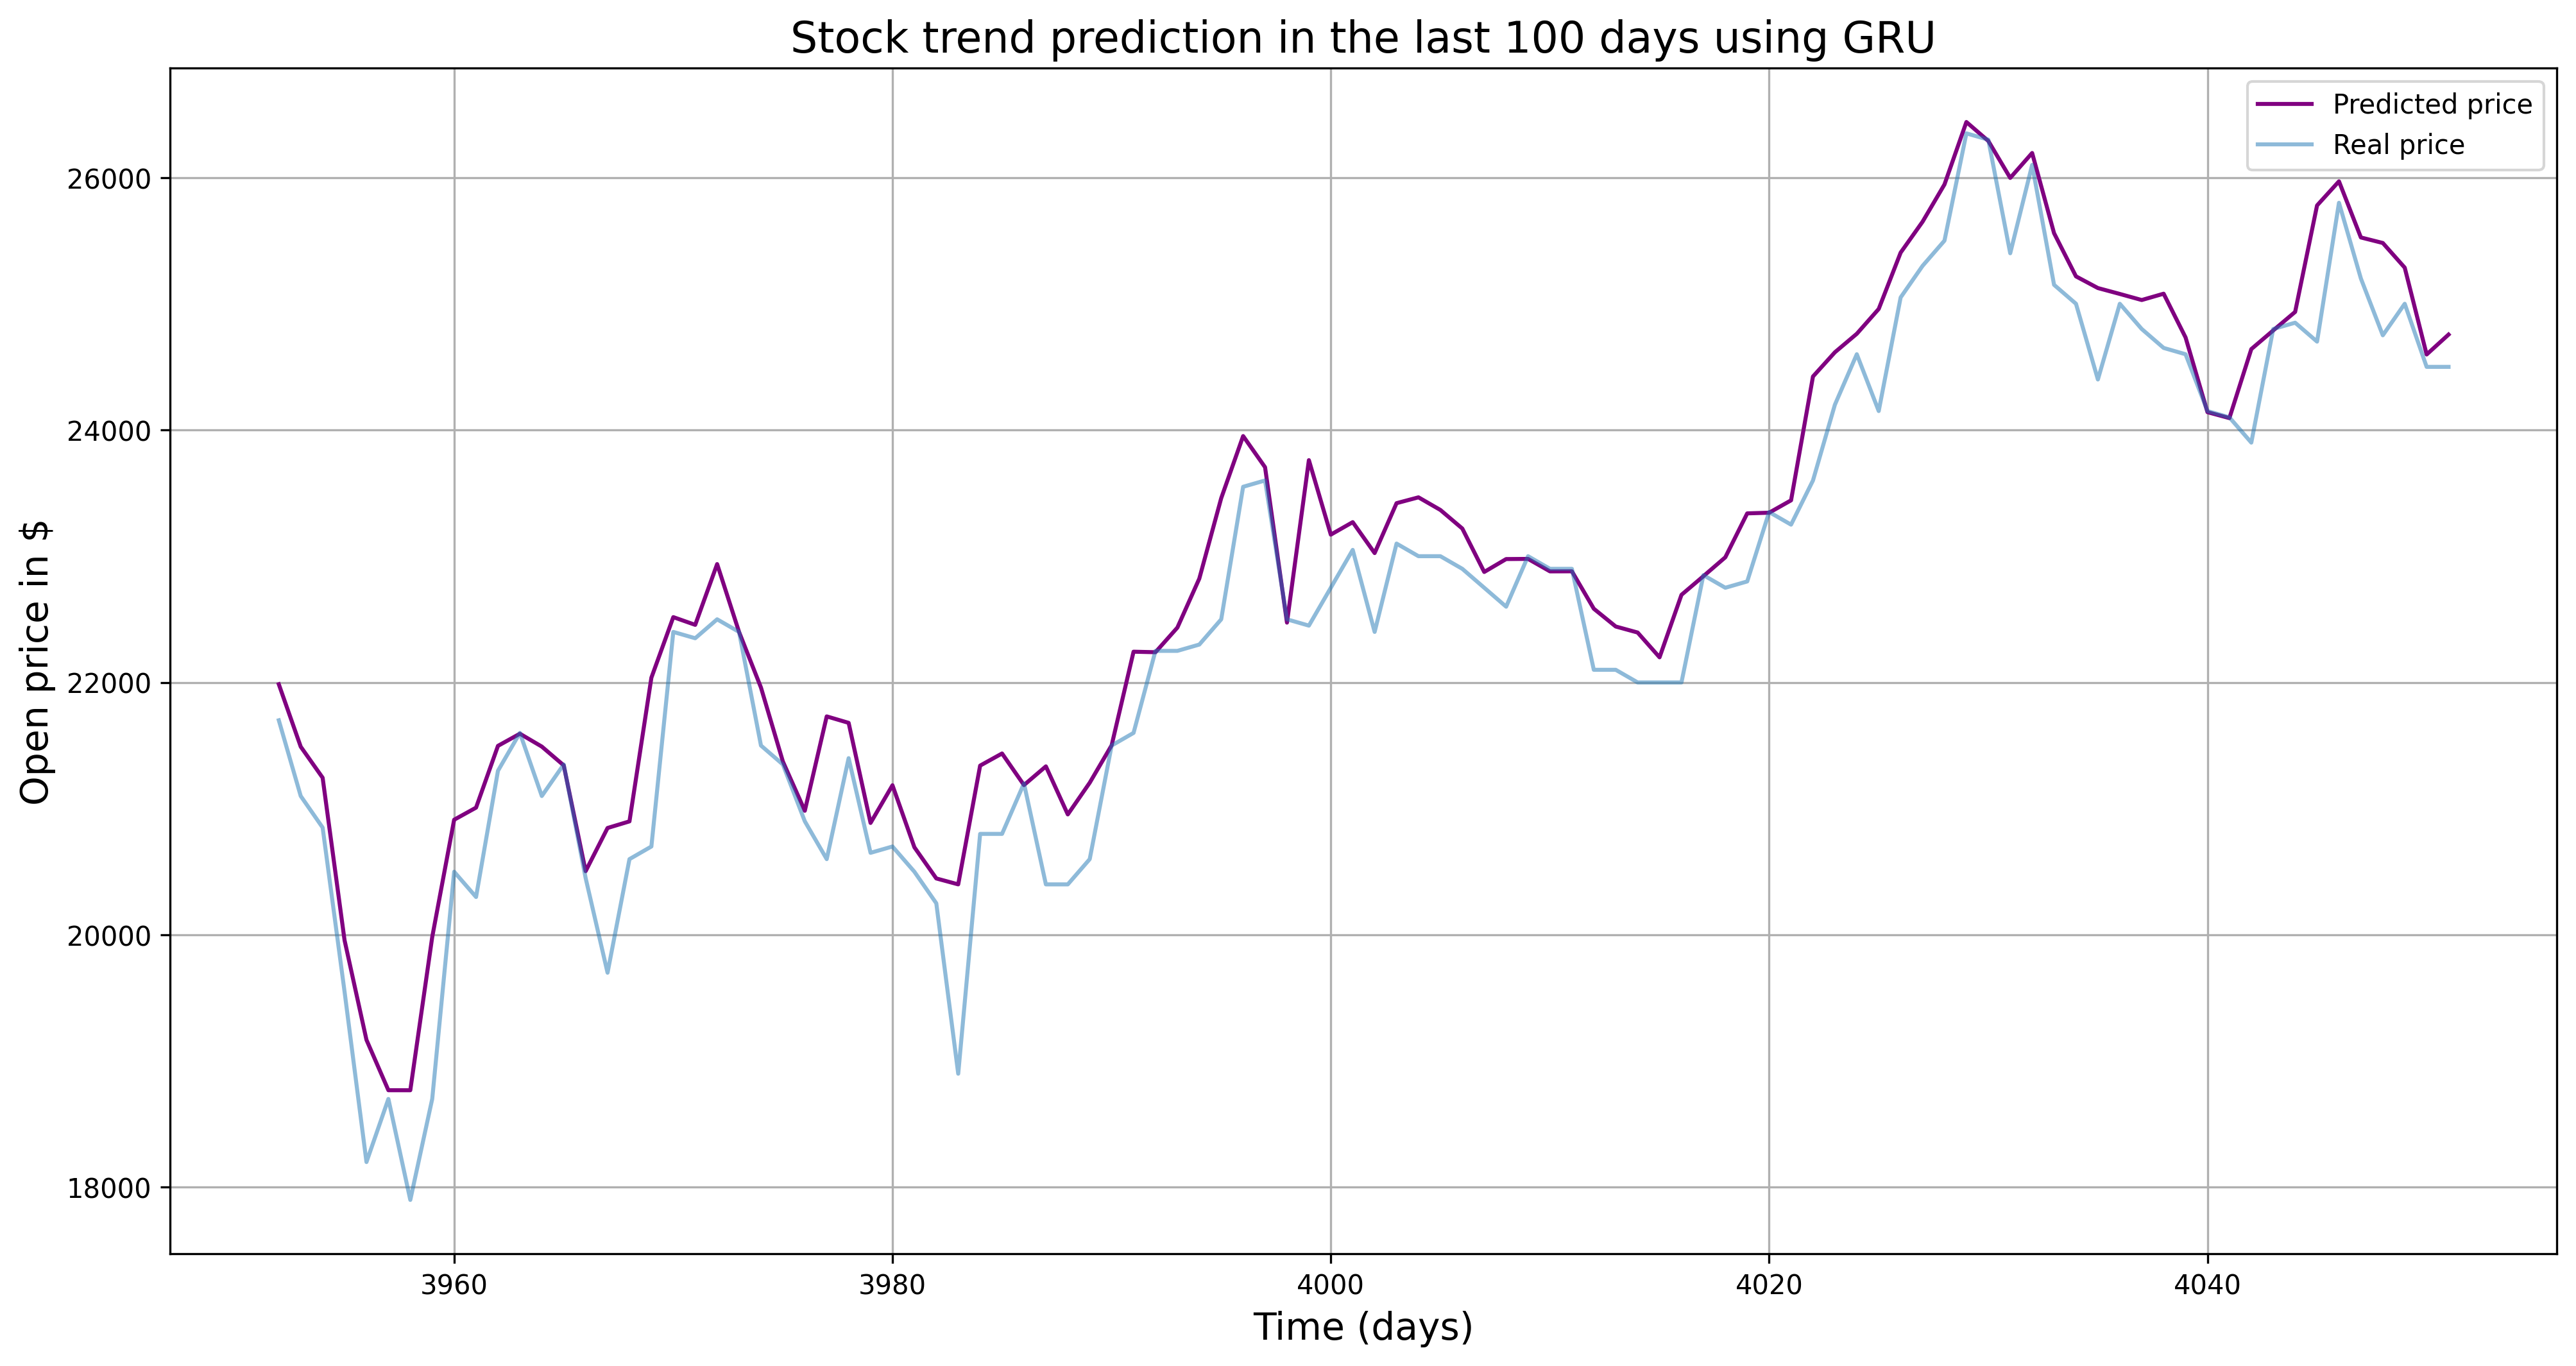

In [87]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['GRUOpenPred01'][-100:], label='Predicted price',color='purple')
plt.plot(vndf['Open'][-100:], label='Real price',alpha=0.5)
plt.title('Stock trend prediction in the last 100 days using GRU', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### 7 day window size

#### -- Train Test Set

In [88]:
vndf.columns[1]

'Open'

In [89]:
"""
Input features (X):
- Window: 30 days of historical data
Labels (y):
- The stock price 1 day after the last day in each window
"""
import numpy as np

X_data = []
y_data = []
window_size = 30
prediction_days = 7

for i in range(len(vndf) - window_size - prediction_days +1):
    data_feature = []
    data_label = []
    
    for j in range(window_size):
        data_feature.append(vndf.iloc[i + j, 2])  # Assuming column index 2 is the open price
    
    # This ensures that the label corresponds to the stock price 7 days after the last day in each window.
    data_label.append(vndf.iloc[i + window_size + prediction_days - 1, 2])
    
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Visualize the training, validation and test set
vndf_plot = vndf['Open']
vndf_plot = vndf_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_test = X_test.shape[0]

# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

#### -- RNN Model

##### -- Start running the model

In [90]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statistics

tscv = TimeSeriesSplit()
loss_result = []
count = 1
for train_index, val_index in tscv.split(X_train_norm):
    x_train, y_train = X_train_norm[train_index], y_train_norm[train_index]
    x_val, y_val = X_train_norm[val_index], y_train_norm[val_index]
    # Compile and train the model with Mean Squared Error loss function
    RNN_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='mse', 
                          metrics=['mse'])
    history = RNN_model.fit(X_train_norm, y_train_norm, validation_data=(x_val,y_val), epochs=100, batch_size=32)
    
    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    # Get prediction on the test data
    y_predict = RNN_model.predict(x_val)
    loss_result.append(mean_squared_error(y_val,y_predict))
    
    print("COMPLETE",count,'/5 FOLDS')
    count += 1

# Calculate the average evaluation metrics across all folds
print("AVERAGE MSE ACROSS ALL FOLDS: ", statistics.mean(loss_result))

Epoch 1/100
101/101 [==============================] - 3s 12ms/step - loss: 1.1968 - mse: 1.1968 - val_loss: 0.1872 - val_mse: 0.1872
Epoch 2/100
101/101 [==============================] - 1s 7ms/step - loss: 1.1896 - mse: 1.1896 - val_loss: 0.1825 - val_mse: 0.1825
Epoch 3/100
101/101 [==============================] - 1s 6ms/step - loss: 1.1868 - mse: 1.1868 - val_loss: 0.1911 - val_mse: 0.1911
Epoch 4/100
101/101 [==============================] - 1s 7ms/step - loss: 1.1893 - mse: 1.1893 - val_loss: 0.1886 - val_mse: 0.1886
Epoch 5/100
101/101 [==============================] - 1s 7ms/step - loss: 1.1795 - mse: 1.1795 - val_loss: 0.1896 - val_mse: 0.1896
Epoch 6/100
101/101 [==============================] - 1s 6ms/step - loss: 1.1803 - mse: 1.1803 - val_loss: 0.1809 - val_mse: 0.1809
Epoch 7/100
101/101 [==============================] - 1s 7ms/step - loss: 1.1727 - mse: 1.1727 - val_loss: 0.2263 - val_mse: 0.2263
Epoch 8/100
101/101 [==============================] - 1s 7ms/step -

In [91]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = RNN_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

26/26 [==============================] - 0s 7ms/step
MSE on the test set:  0.39180809797244603


In [328]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

##### -- Visualizing the results

In [99]:
# Store predicted value
openPred = []
for val in y_pred_denorm:
  for i in val:
    openPred.append(i)
start_index = len(openPred)
vndf['RNNOpenPred7'] = pd.Series(openPred, index=vndf.index[len(vndf)-len(openPred):])
vndf.head(-10)

Unnamed: 0     Open     High      Low    Close   Volume TradingDate  \
0              0   5050.0   8234.0   6532.0   7147.0    56500  2006-11-21   
1              1   6038.0   7861.0   7136.0   7394.0    62300  2006-11-22   
2              2   6093.0   7959.0   7136.0   7597.0    69900  2006-11-23   
3              3   5928.0   8344.0   7685.0   8058.0    63600  2006-11-24   
4              4   6203.0   8860.0   7410.0   8058.0    42400  2006-11-27   
...          ...      ...      ...      ...      ...      ...         ...   
4037        4037  24800.0  25050.0  24550.0  24650.0  1924125  2023-02-08   
4038        4038  24650.0  25100.0  24500.0  24500.0  3227424  2023-02-09   
4039        4039  24600.0  24750.0  24200.0  24200.0  2009129  2023-02-10   
4040        4040  24150.0  24150.0  23800.0  23900.0  2593039  2023-02-13   
4041        4041  24100.0  24100.0  23800.0  23850.0  1439656  2023-02-14   

          openPred  GRUOpenPred01   GRUOpenPred  RNNOpenPred7  
0              NaN            NaN           NaN           NaN  
1              NaN            NaN           NaN           NaN  
2              NaN            NaN           NaN           NaN  
3              NaN            NaN           NaN           NaN  
4              NaN            NaN           NaN           NaN  
...            ...            ...           ...           ...  
4037  25098.025391   25029.552734  25029.552734  25029.552734  
4038  25150.859375   25079.628906  25079.628906  25079.628906  
4039  24829.873047   24733.236328  24733.236328  24733.236328  
4040  24285.652344   24141.179688  24141.179688  24141.179688  
4041  24232.820312   24094.044922  24094.044922  24094.044922  

[4042 rows x 11 columns]

### 🎯 Predicting the stock prices for **the next 7 days**, starting from the most recent trading day.

In [96]:
vndf_pred7 = vndf.copy()
# Sort the data by date in ascending order
vndf_pred7.sort_values('TradingDate', inplace=True)
vndf_pred7.reset_index(drop=True, inplace=True)
for i in range(7):
    # Get the last 7 days of open prices
    last_7_days = vndf_pred7['Open'].tail(7).values

    # Normalize the last 7 days of open prices
    last_7_days_norm = (last_7_days - np.mean(last_7_days)) / np.std(last_7_days)

    # Reshape the data to match the input shape of the model
    last_7_days_norm = last_7_days_norm.reshape(1, 7, 1)

    # Generate prediction for the next day's open price
    next_day_norm = RNN_model.predict(last_7_days_norm)

    # Denormalize the prediction
    next_day = (next_day_norm * np.std(last_7_days)) + np.mean(last_7_days)

    # Convert index to DatetimeIndex
    vndf_pred7['TradingDate'] = pd.to_datetime(vndf_pred7['TradingDate'])

    # Add the predicted next day's open price to the DataFrame
    next_day_date = vndf_pred7['TradingDate'].iloc[-1] + pd.DateOffset(days=1)
    vndf_pred7 = vndf_pred7.append({'TradingDate': next_day_date, 'Open': next_day[0, 0]}, ignore_index=True)

    # Print the predicted next day's open price
    print("Predicted next day's open price:", next_day[0, 0])
vndf_pred7.head(-7)

1/1 [==============================] - 0s 30ms/step
Predicted next day's open price: 25065.13
1/1 [==============================] - 0s 16ms/step
Predicted next day's open price: 25070.63
1/1 [==============================] - 0s 17ms/step
Predicted next day's open price: 24917.68
1/1 [==============================] - 0s 19ms/step
Predicted next day's open price: 24876.176
1/1 [==============================] - 0s 16ms/step
Predicted next day's open price: 24950.043
1/1 [==============================] - 0s 15ms/step
Predicted next day's open price: 24895.717
1/1 [==============================] - 0s 17ms/step
Predicted next day's open price: 24922.195


Unnamed: 0     Open     High      Low    Close     Volume TradingDate  \
0            0.0   5050.0   8234.0   6532.0   7147.0    56500.0  2006-11-21   
1            1.0   6038.0   7861.0   7136.0   7394.0    62300.0  2006-11-22   
2            2.0   6093.0   7959.0   7136.0   7597.0    69900.0  2006-11-23   
3            3.0   5928.0   8344.0   7685.0   8058.0    63600.0  2006-11-24   
4            4.0   6203.0   8860.0   7410.0   8058.0    42400.0  2006-11-27   
...          ...      ...      ...      ...      ...        ...         ...   
4047      4047.0  25200.0  25550.0  24850.0  24850.0  2654851.0  2023-02-22   
4048      4048.0  24750.0  25500.0  24250.0  25400.0  3862411.0  2023-02-23   
4049      4049.0  25000.0  25300.0  24550.0  24600.0  2228733.0  2023-02-24   
4050      4050.0  24500.0  24600.0  24100.0  24250.0  3109431.0  2023-02-27   
4051      4051.0  24500.0  24750.0  24250.0  24400.0  6149990.0  2023-02-28   

          openPred  GRUOpenPred01   GRUOpenPred  
0              NaN            NaN           NaN  
1              NaN            NaN           NaN  
2              NaN            NaN           NaN  
3              NaN            NaN           NaN  
4              NaN            NaN           NaN  
...            ...            ...           ...  
4047  25579.996094   25525.257812  25525.257812  
4048  25529.894531   25481.429688  25481.429688  
4049  25347.835938   25286.234375  25286.234375  
4050  24727.720703   24598.105469  24598.105469  
4051  24877.029297   24755.933594  24755.933594  

[4052 rows x 10 columns]

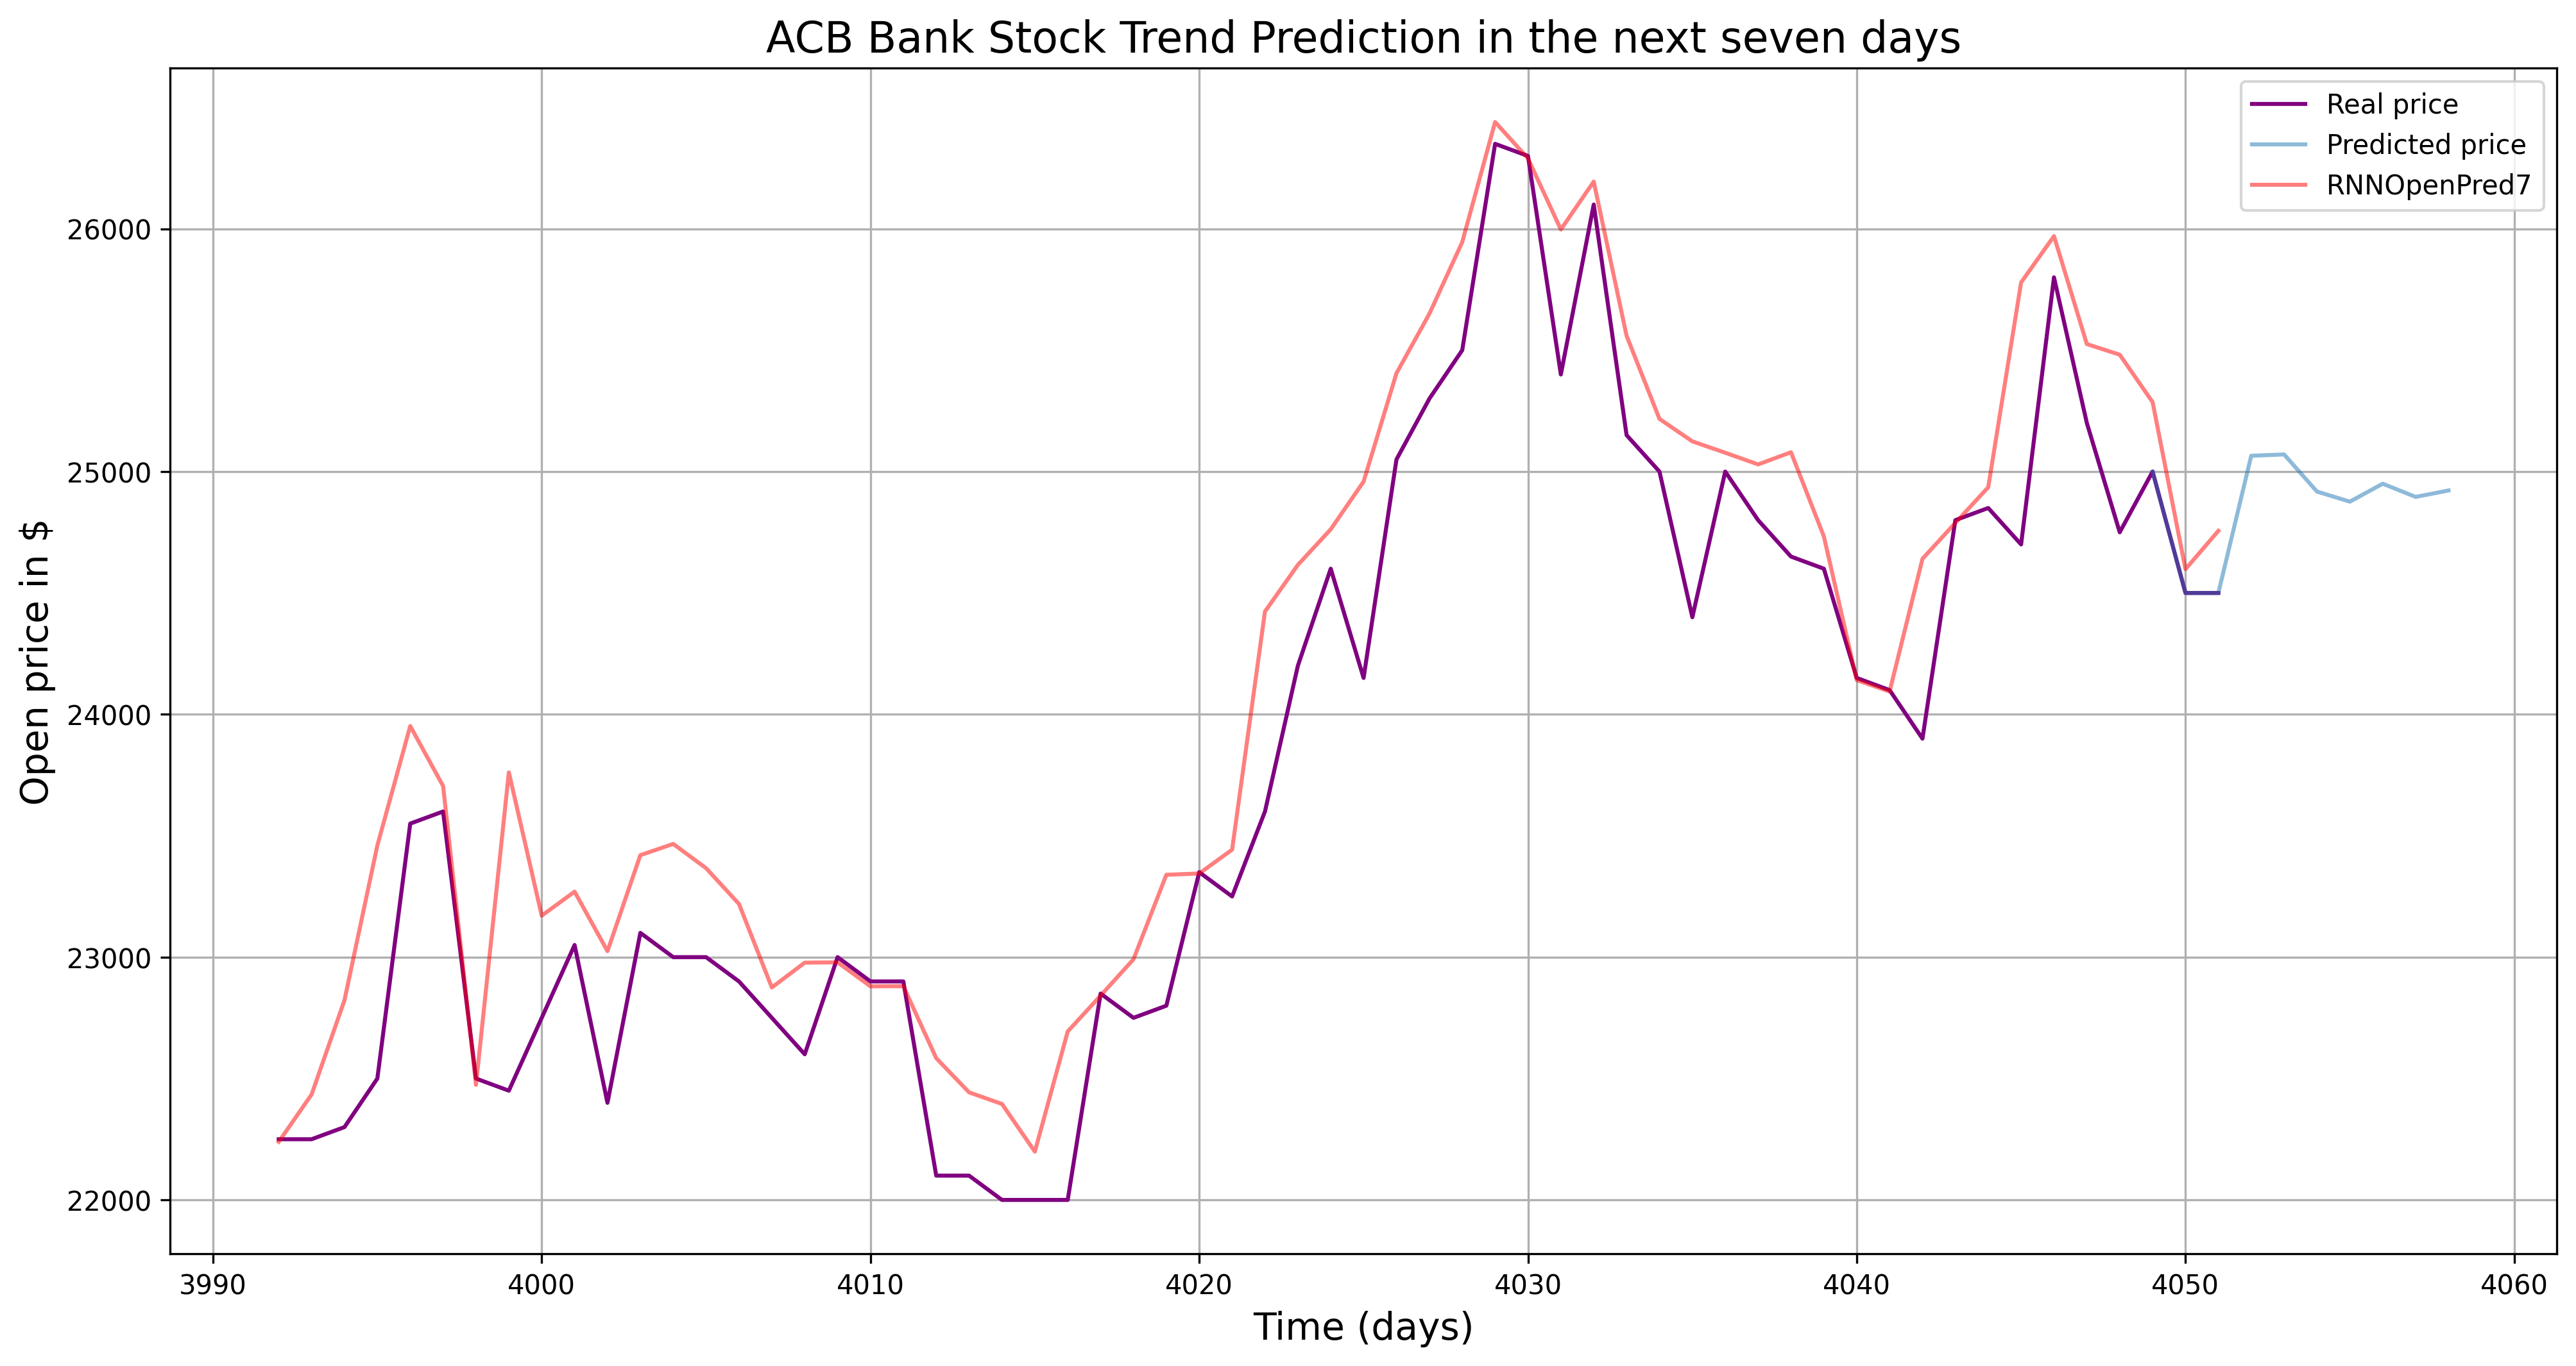

In [110]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['Open'][-60:], label='Real price',color='purple')
plt.plot(vndf_pred7['Open'][-10:], label='Predicted price',alpha=0.5)
plt.plot(vndf['RNNOpenPred7'][-60:], label='RNNOpenPred7',alpha=0.5,color='red')
plt.title('ACB Bank Stock Trend Prediction in the next seven days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

#### -- GRU

In [118]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, GRU

GRU_model=Sequential()
GRU_model.add(GRU(32,return_sequences=True,input_shape=(window_size,1)))
GRU_model.add(GRU(32,return_sequences=True))
GRU_model.add(GRU(32))
GRU_model.add(Dropout(0.20))
GRU_model.add(Dense(1))
GRU_model.compile(loss='mean_squared_error',optimizer='adam')

GRU_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 30, 32)            3360      
                                                                 
 gru_7 (GRU)                 (None, 30, 32)            6336      
                                                                 
 gru_8 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


##### -- Start running the model

In [119]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statistics

tscv = TimeSeriesSplit()
loss_result = []
count = 1
for train_index, val_index in tscv.split(X_train_norm):
    x_train, y_train = X_train_norm[train_index], y_train_norm[train_index]
    x_val, y_val = X_train_norm[val_index], y_train_norm[val_index]
    # Compile and train the model with Mean Squared Error loss function
    GRU_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
                          loss='mse', 
                          metrics=['mse'])
    history = GRU_model.fit(X_train_norm, y_train_norm, validation_data=(x_val,y_val), epochs=100, batch_size=32)
    
    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    # Get prediction on the test data
    y_predict = GRU_model.predict(x_val)
    loss_result.append(mean_squared_error(y_val,y_predict))
    
    print("COMPLETE",count,'/5 FOLDS')
    count += 1

# Calculate the average evaluation metrics across all folds
print("AVERAGE MSE ACROSS ALL FOLDS: ", statistics.mean(loss_result))

Epoch 1/100
101/101 [==============================] - 4s 15ms/step - loss: 1.2516 - mse: 1.2516 - val_loss: 0.2137 - val_mse: 0.2137
Epoch 2/100
101/101 [==============================] - 1s 8ms/step - loss: 1.2107 - mse: 1.2107 - val_loss: 0.2152 - val_mse: 0.2152
Epoch 3/100
101/101 [==============================] - 1s 8ms/step - loss: 1.2187 - mse: 1.2187 - val_loss: 0.1915 - val_mse: 0.1915
Epoch 4/100
101/101 [==============================] - 1s 8ms/step - loss: 1.2096 - mse: 1.2096 - val_loss: 0.1859 - val_mse: 0.1859
Epoch 5/100
101/101 [==============================] - 1s 9ms/step - loss: 1.2026 - mse: 1.2026 - val_loss: 0.1833 - val_mse: 0.1833
Epoch 6/100
101/101 [==============================] - 1s 9ms/step - loss: 1.2022 - mse: 1.2022 - val_loss: 0.2032 - val_mse: 0.2032
Epoch 7/100
101/101 [==============================] - 1s 8ms/step - loss: 1.2022 - mse: 1.2022 - val_loss: 0.1856 - val_mse: 0.1856
Epoch 8/100
101/101 [==============================] - 1s 8ms/step -

In [127]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = GRU_model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

26/26 [==============================] - 0s 9ms/step
MSE on the test set:  0.5226935066769338


In [128]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

##### -- Visualizing the results

In [129]:
# Create a function to signal when to buy or sell stock
OpenPred7 = []
for val in y_pred_denorm:
  for i in val:
    OpenPred7.append(i)
start_index = len(OpenPred7)
vndf['GRUOpenPred07'] = pd.Series(OpenPred7, index=vndf.index[len(vndf)-len(OpenPred7):])
vndf.head(-10)

Unnamed: 0     Open     High      Low    Close   Volume TradingDate  \
0              0   5050.0   8234.0   6532.0   7147.0    56500  2006-11-21   
1              1   6038.0   7861.0   7136.0   7394.0    62300  2006-11-22   
2              2   6093.0   7959.0   7136.0   7597.0    69900  2006-11-23   
3              3   5928.0   8344.0   7685.0   8058.0    63600  2006-11-24   
4              4   6203.0   8860.0   7410.0   8058.0    42400  2006-11-27   
...          ...      ...      ...      ...      ...      ...         ...   
4037        4037  24800.0  25050.0  24550.0  24650.0  1924125  2023-02-08   
4038        4038  24650.0  25100.0  24500.0  24500.0  3227424  2023-02-09   
4039        4039  24600.0  24750.0  24200.0  24200.0  2009129  2023-02-10   
4040        4040  24150.0  24150.0  23800.0  23900.0  2593039  2023-02-13   
4041        4041  24100.0  24100.0  23800.0  23850.0  1439656  2023-02-14   

      VNOpenPred01  RNNOpenPred1  RNNOpenPred7  GRUOpenPred07  
0              NaN           NaN           NaN            NaN  
1              NaN           NaN           NaN            NaN  
2              NaN           NaN           NaN            NaN  
3              NaN           NaN           NaN            NaN  
4              NaN           NaN           NaN            NaN  
...            ...           ...           ...            ...  
4037  25021.828125  24985.265625  26536.183594   27447.183594  
4038  25071.744141  25025.095703  26231.781250   27024.187500  
4039  24723.269531  24725.671875  26284.123047   27058.896484  
4040  24124.906250  24209.458984  25515.925781   26818.335938  
4041  24079.091797  24169.625000  25298.132812   26445.064453  

[4042 rows x 11 columns]

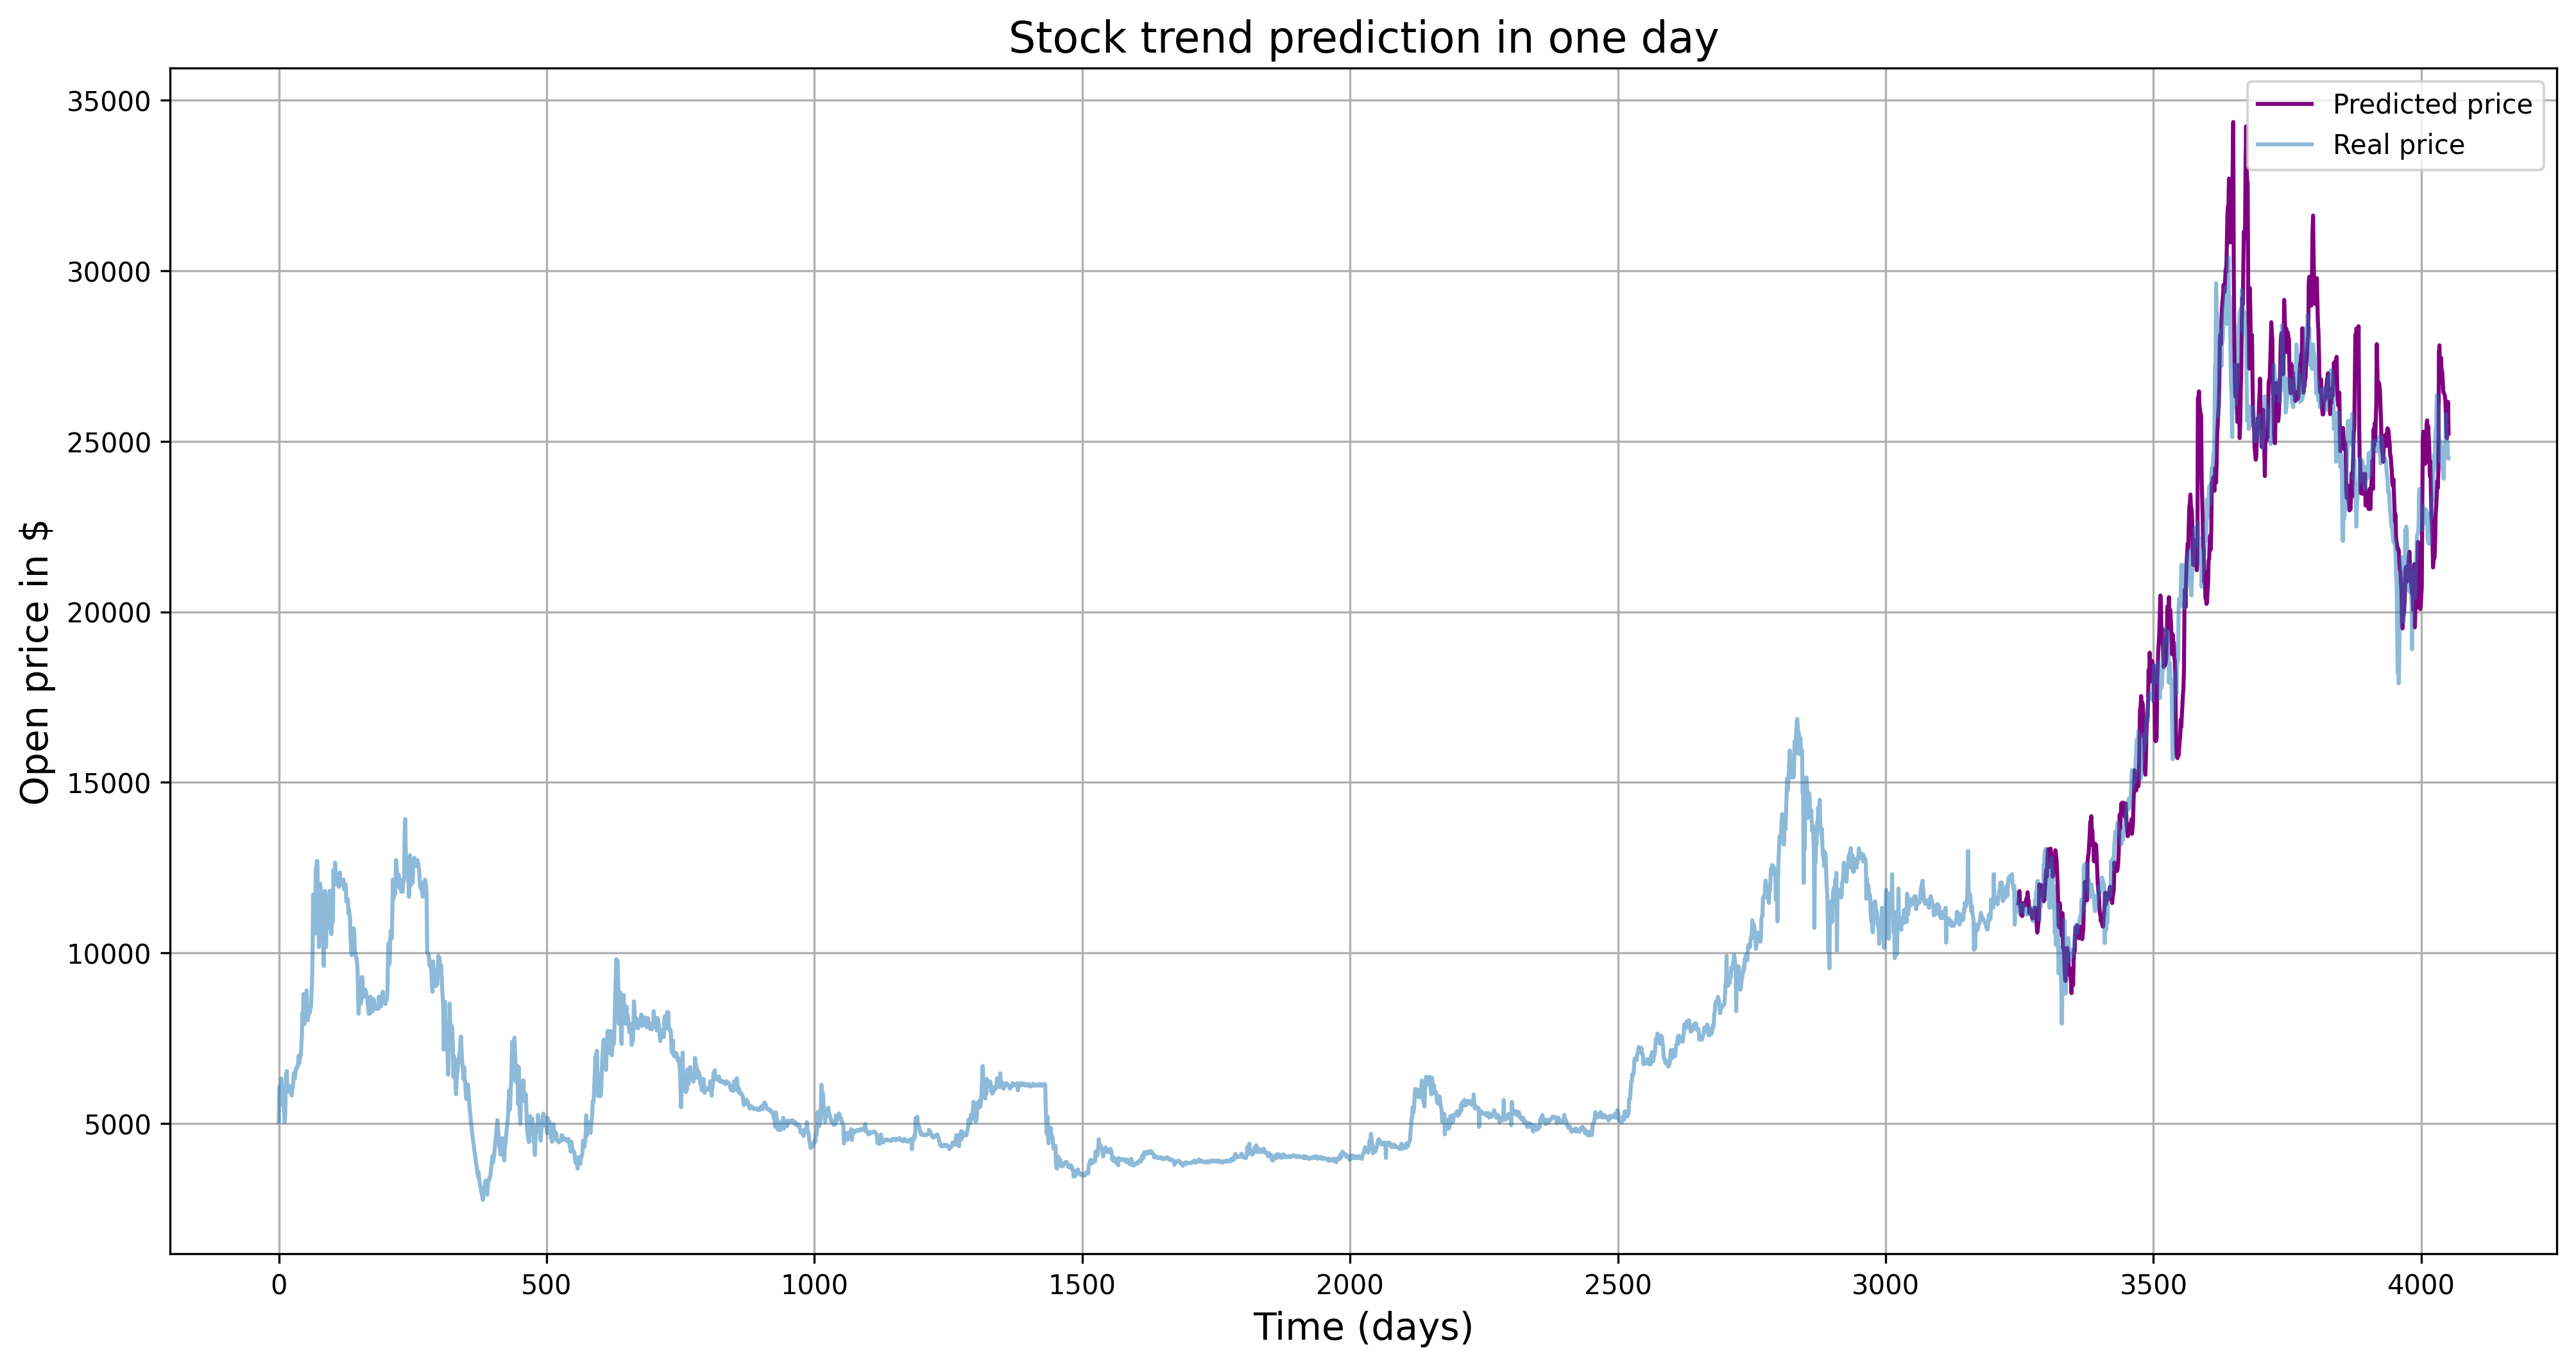

In [130]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['GRUOpenPred07'], label='Predicted price',color='purple')
plt.plot(vndf['Open'], label='Real price',alpha=0.5)
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

Zoom in to the prediction in the most recent 100 days

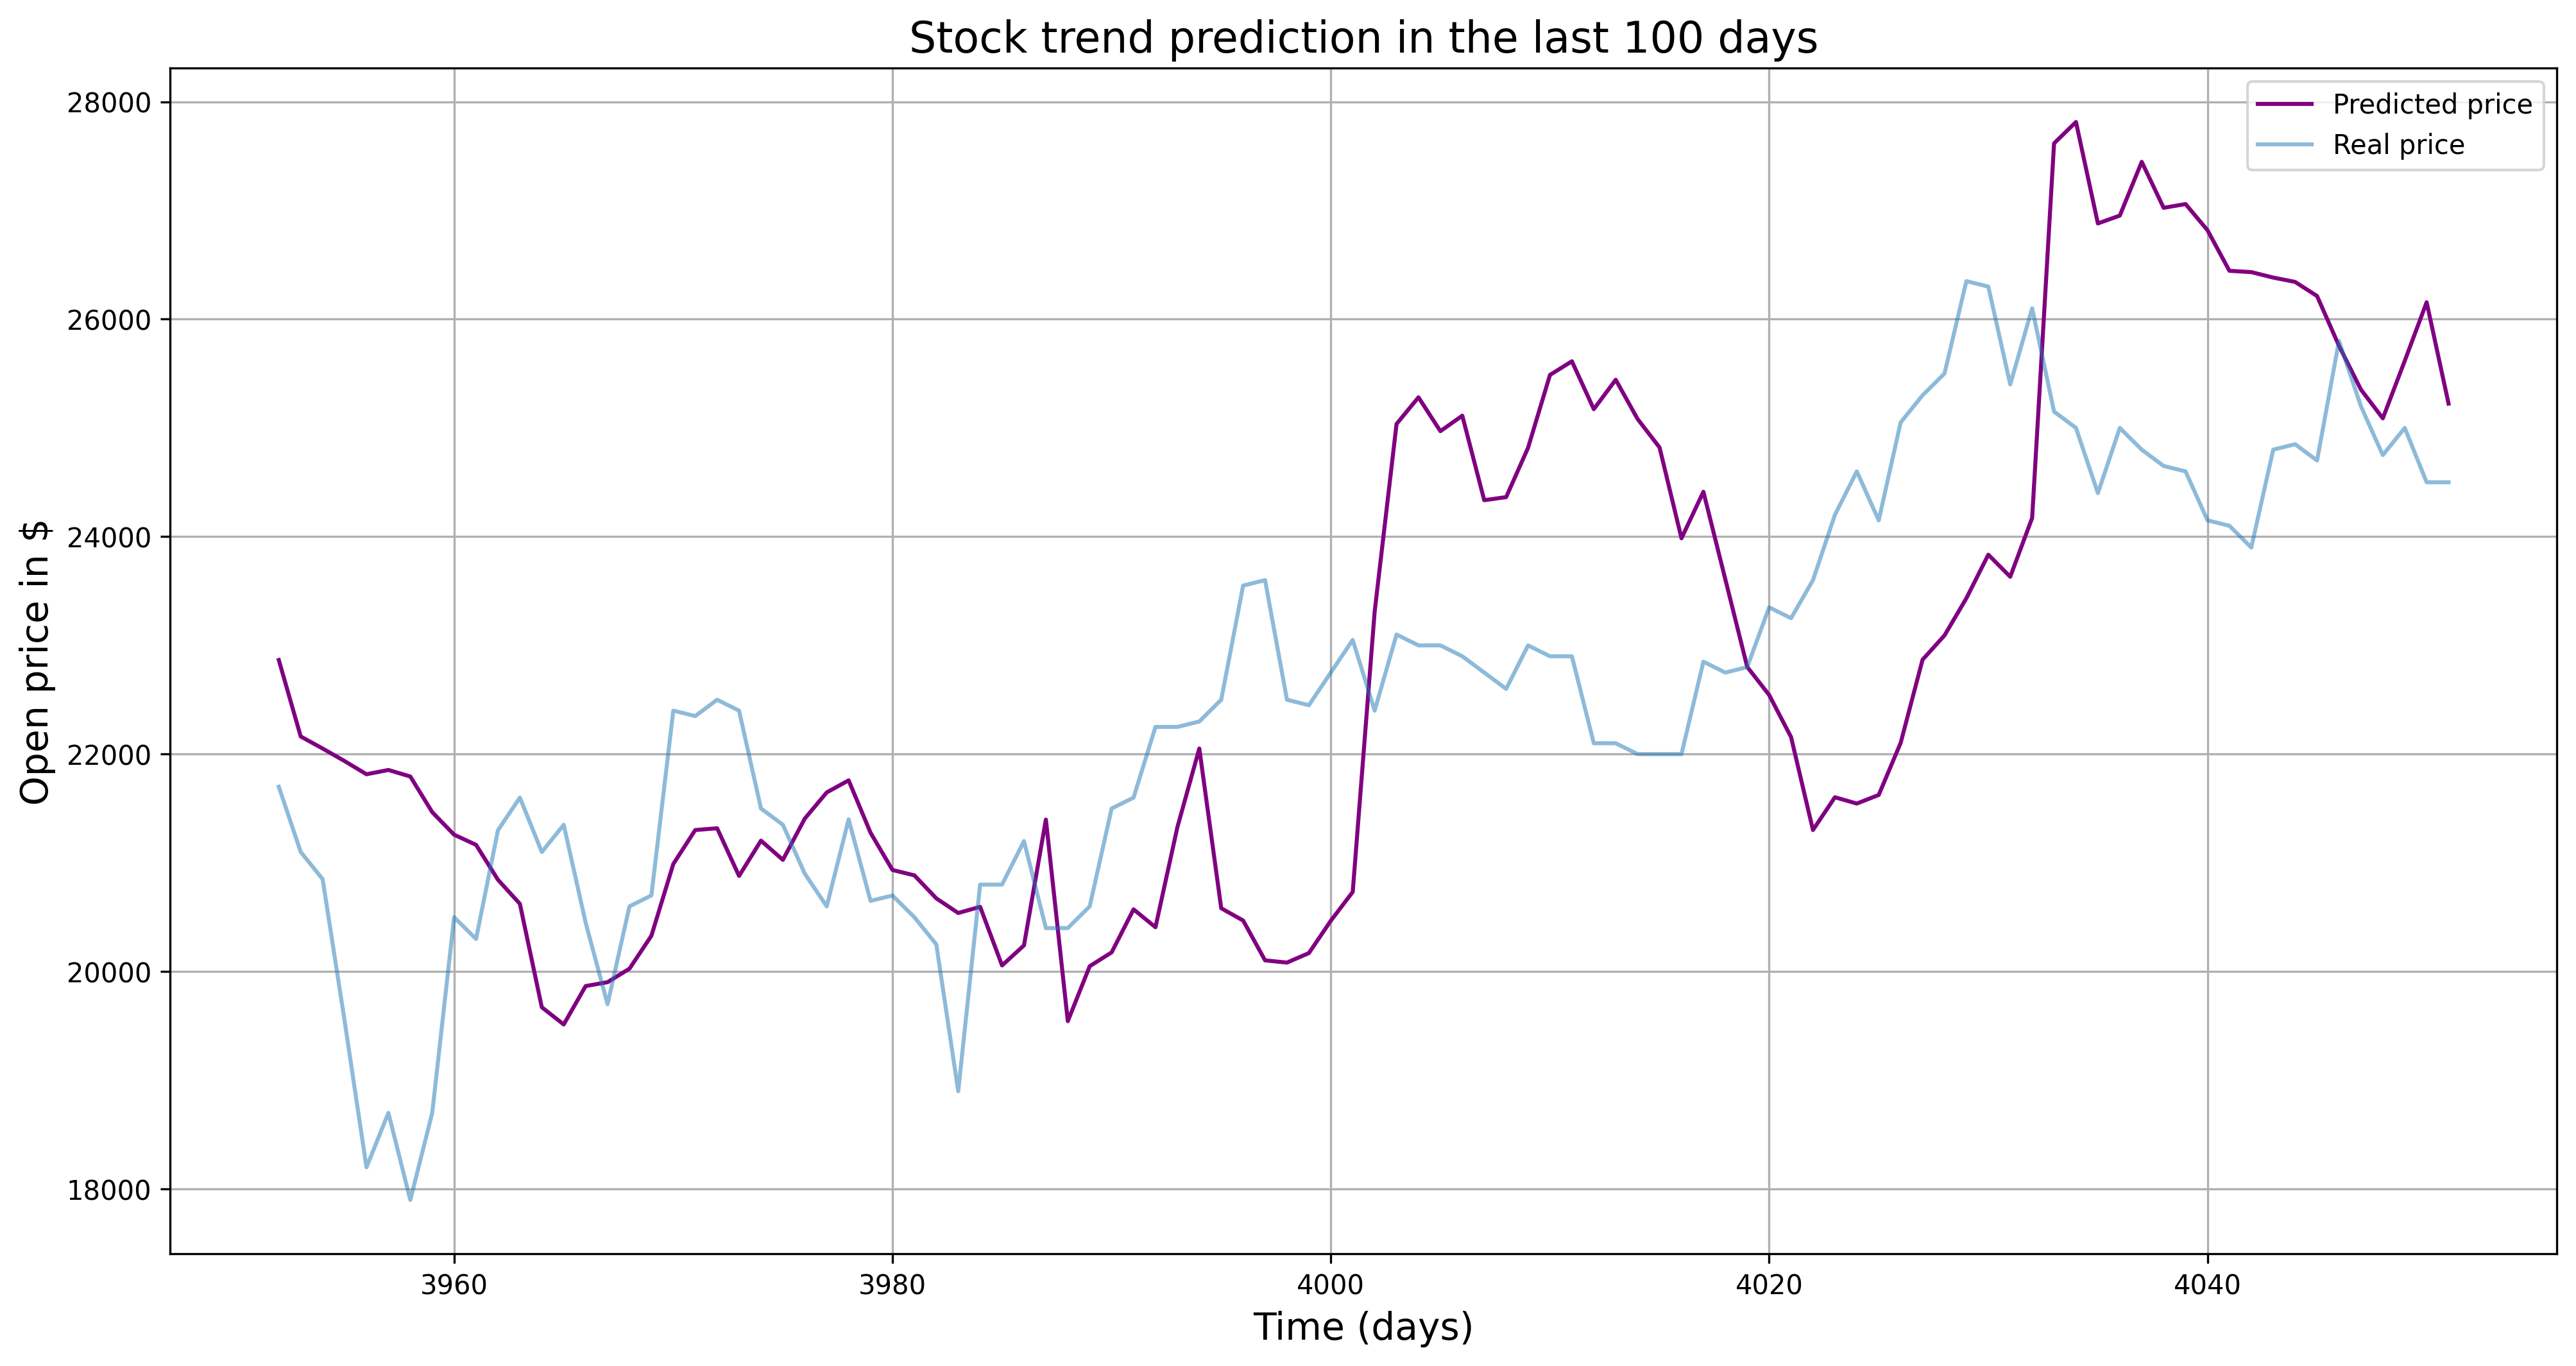

In [132]:
# Visualize predited stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(vndf['GRUOpenPred07'][-100:], label='Predicted price',color='purple')
plt.plot(vndf['Open'][-100:], label='Real price',alpha=0.5)
plt.title('Stock trend prediction in the last 100 days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# Portfolio Management

In [135]:
df = pd.read_csv('D:\Final-project-stock-FUV\data-vn-20230228\data-vn-20230228\industry-analysis\ACB-VNINDEX-Industry.csv')
bank_ticker = df['ticker'].tolist()
print(bank_ticker)

['ACB', 'VCB', 'BID', 'CTG', 'VPB', 'TCB', 'MBB', 'SSB', 'STB', 'HDB', 'VIB', 'TPB', 'SHB', 'EIB', 'MSB', 'LPB', 'OCB', 'BAB', 'NAB', 'ABB']


In [136]:
import pandas as pd

file_paths = []
for ticker in bank_ticker[:10]:
    file_path = 'D:/Final-project-stock-FUV/data-vn-20230228/data-vn-20230228/stock-historical-data/' + ticker + '-VNINDEX-History.csv'
    file_paths.append(file_path)

dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

ACBdf, VCBdf, BIDdf, CTGdf, VPBdf, TCBdf, MBBdf, SSBdf, STBdf, HDBdf = dfs[0], dfs[1], dfs[2], dfs[3], dfs[4], dfs[5], dfs[6], dfs[7], dfs[8], dfs[9]

last_trading_dates = []
for df in dfs:
    last_trading_date = pd.to_datetime(df['TradingDate']).max()
    last_trading_dates.append(last_trading_date)
# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=True)

# Print the last trading date for each DataFrame
for ticker, last_trading_date in zip(['ACB', 'VCB', 'BID', 'CTG', 'VPB', 'TCB', 'MBB', 'SSB', 'STB', 'HDB'], last_trading_dates):
    print(f"Last trading date of {ticker}df: {last_trading_date}")

Last trading date of ACBdf: 2023-02-28 00:00:00
Last trading date of VCBdf: 2023-02-28 00:00:00
Last trading date of BIDdf: 2023-02-28 00:00:00
Last trading date of CTGdf: 2023-02-28 00:00:00
Last trading date of VPBdf: 2023-02-28 00:00:00
Last trading date of TCBdf: 2023-02-28 00:00:00
Last trading date of MBBdf: 2023-02-28 00:00:00
Last trading date of SSBdf: 2023-02-28 00:00:00
Last trading date of STBdf: 2023-02-28 00:00:00
Last trading date of HDBdf: 2023-02-28 00:00:00


In [113]:
### LOOP OVER HISTORICAL DATASET OF EACH BACK
dfs = [ACBdf, VCBdf, BIDdf, CTGdf, VPBdf, TCBdf, MBBdf, SSBdf, STBdf, HDBdf]
for i, df in enumerate (dfs):   
    """
    Input features (X):
    - Window: 30 days of historical data
    Labels (y):
    - The stock price 1 day after the last day in each window
    """
    import numpy as np

    X_data = []
    y_data = []
    window_size = 30
    prediction_days = 0

    for i in range(len(df) - window_size - prediction_days +1):
        data_feature = []
        data_label = []
        
        for j in range(window_size):
            data_feature.append(df.iloc[i + j, 2])  # Assuming column index 2 is the open price
        
        # This ensures that the label corresponds to the stock price 7 days after the last day in each window.
        data_label.append(df.iloc[i + window_size + prediction_days - 1, 2])
        
        X_data.append(np.array(data_feature).reshape(window_size, 1))
        y_data.append(np.array(data_label))

    """
    Split the data into training, validation and test set
    """

    # Import the library
    from sklearn.model_selection import train_test_split

    # Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

    # Convert from lists to Numpy arrays for reshaping purpose
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Reshape the numpy array to fit the neural network input shape requirement
    X_train = X_train.reshape(X_train.shape[0], window_size, 1)
    X_test = X_test.reshape(X_test.shape[0], window_size, 1)

    # Visualize the training, validation and test set
    df_plot = df['Open']
    df_plot = df_plot.reset_index(drop=False)

    # Get lengths of the three subsets
    size_train = X_train.shape[0]
    size_test = X_test.shape[0]

    # MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
    X_train_norm = X_train.copy()
    y_train_norm = y_train.copy()
    for i in range(0, len(X_train)):
        min_feature = np.min(X_train[i])
        max_feature = np.max(X_train[i])
        X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
        y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

    # MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
    X_test_norm = X_test.copy()
    y_test_norm = y_test.copy()
    for i in range(0, len(X_test)):
        min_feature = np.min(X_test[i])
        max_feature = np.max(X_test[i])
        X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
        y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    from sklearn.metrics import mean_squared_error

    # Get prediction on the test data
    y_pred_norm = RNN_model.predict(X_test_norm)

    # Convert the result back to stock price (i.e., de-normalization) for visualization purpose
    y_pred_denorm = y_pred_norm
    for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
        min_feature = np.min(X_test[i])
        max_feature = np.max(X_test[i])
        y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

    # Store predicted values
    openPred = []
    for val in y_pred_denorm:
        for i in val:
            openPred.append(i)
    start_index = -len(openPred)
    df['openPred'] = pd.Series(openPred, index=df.index[len(df)-len(openPred):])


8/8 [==============================] - 0s 2ms/step


In [139]:
"""
ACB
"""
ACBdf2 = pd.DataFrame()
ACBdf2["Open"]=ACBdf["Open"]
ACBdf2['EMA']=ACBdf['EMA']
ACBdf2['openPred']=ACBdf['openPred']

"""
VCB
"""
VCBdf2 = pd.DataFrame()
VCBdf2["Open"]=VCBdf["Open"]
VCBdf2['EMA']=VCBdf['EMA']
VCBdf2['openPred']=VCBdf['openPred']

time_range = 7  # Time range in days (eliminate signals that are too closed to each other e.g. within 7 days trade)

buySellSignals = buySell(VCBdf2, time_range)
VCBdf2['Buy Signal Price'] = buySellSignals[0]
VCBdf2['Sell Signal Price'] = buySellSignals[1]
"""
BID
"""
BIDdf2 = pd.DataFrame()
BIDdf2["Open"]=BIDdf["Open"]
BIDdf2['EMA']=BIDdf['EMA']
BIDdf2['openPred']=BIDdf['openPred']

time_range = 7  # Time range in days (eliminate signals that are too closed to each other e.g. within 7 days trade)

buySellSignals = buySell(BIDdf2, time_range)
BIDdf2['Buy Signal Price'] = buySellSignals[0]
BIDdf2['Sell Signal Price'] = buySellSignals[1]

KeyError: 'EMA'

In [140]:
import pandas as pd
import yfinance as yf
from datetime import datetime

start_date = datetime.now() - pd.DateOffset(months=3)
end_date = datetime.now()

tickers = ['AXP','PYPL','SQ','GPN','FIS','FISV','V','MA']
# Apple, Microsoft, Netflix, and Google

ticker_list = []

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    ticker_list.append(data)

portdf = pd.concat(ticker_list, keys=tickers, names=['Ticker', 'Date'])
portdf = portdf.reset_index()
portdf.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ticker     496 non-null    object        
 1   Date       496 non-null    datetime64[ns]
 2   Open       496 non-null    float64       
 3   High       496 non-null    float64       
 4   Low        496 non-null    float64       
 5   Close     

In [141]:
import plotly.express as px
fig = px.line(portdf, x='Date', 
              y='Close', 
              color='Ticker', 
              title="Stock Market Performance for the Last 3 Months")
fig.show()

In [142]:
#Compare the performance of companies
fig = px.area(portdf, x='Date', y='Close', color='Ticker',
              facet_col='Ticker',
              labels={'Date':'Date', 'Close':'Closing Price', 'Ticker':'Company'},
              title='Stock Prices for Apple, Microsoft, Netflix, and Google')
fig.show()

[*********************100%***********************]  1 of 1 completed
Loaded AXP num values = 12858
[*********************100%***********************]  1 of 1 completed
Loaded PYPL num values = 1989
[*********************100%***********************]  1 of 1 completed
Loaded SQ num values = 1892
[*********************100%***********************]  1 of 1 completed
Loaded GPN num values = 5627
[*********************100%***********************]  1 of 1 completed
Loaded FIS num values = 5519
[*********************100%***********************]  1 of 1 completed
Loaded FISV num values = 9242
[*********************100%***********************]  1 of 1 completed
Loaded V num values = 3825
[*********************100%***********************]  1 of 1 completed
Loaded MA num values = 4281


AXP       PYPL     SQ        GPN        FIS       FISV  \
Date                                                                       
2015-11-19  64.931778  36.189999  13.07  69.627403  59.338371  48.330002   
2015-11-20  64.646133  36.360001  12.85  69.617653  59.634716  48.395000   

                    V         MA  
Date                              
2015-11-19  76.136803  94.508583  
2015-11-20  76.174797  95.053131

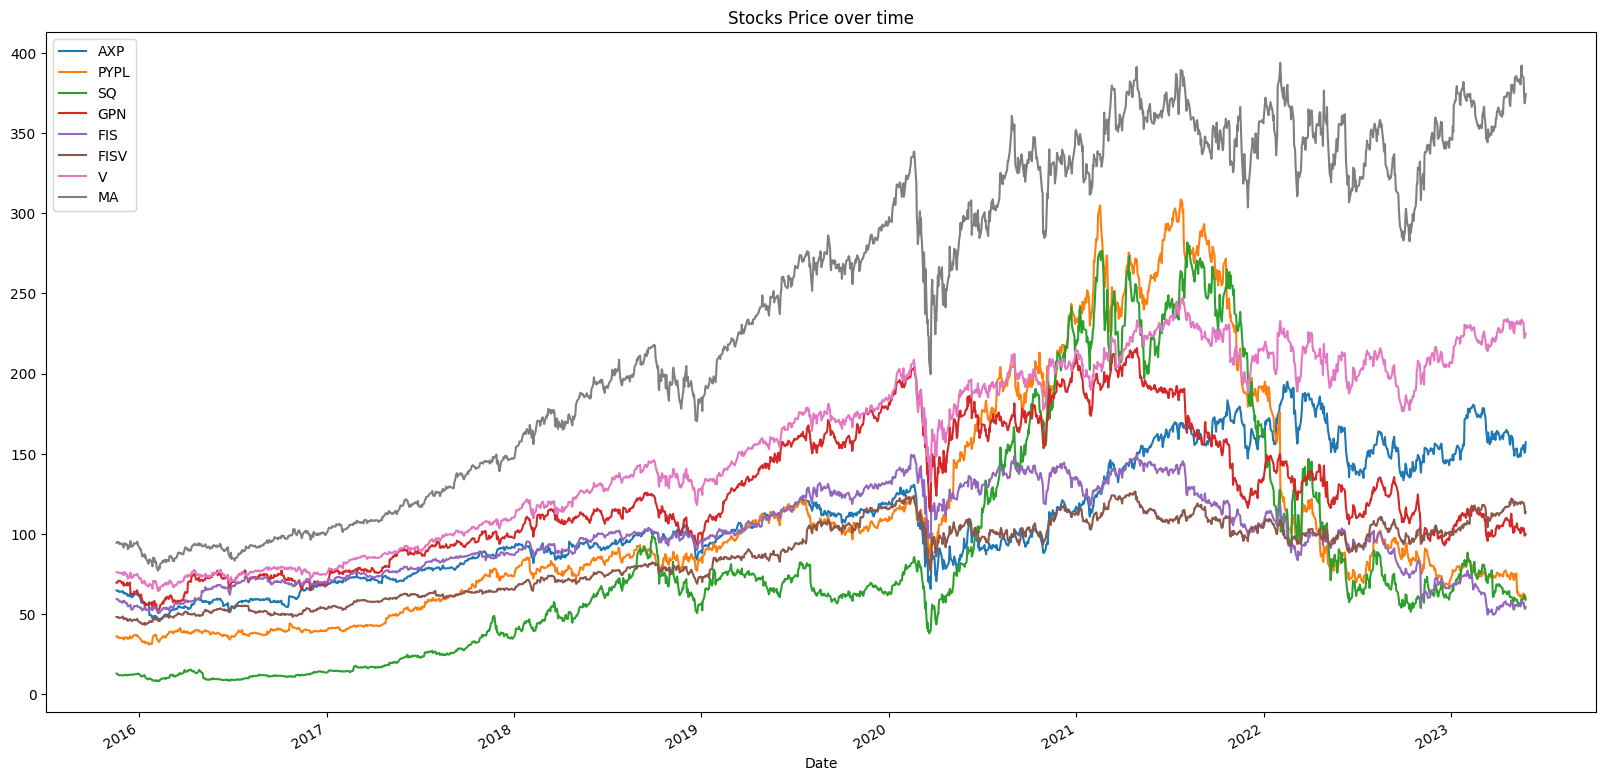

In [143]:
cached_data={}
def stock_hist(symbol, start=None, end=None, cached_data=cached_data):
    '''Convenience function to get cached data '''
    if not symbol in cached_data:
        cached_data[symbol] = yf.download(symbol)
        print(F'Loaded {symbol} num values = {len(cached_data[symbol])}')
    return cached_data[symbol]

tickers = ['AXP','PYPL','SQ','GPN','FIS','FISV','V','MA']
N = len(tickers)
historical  = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in tickers), axis=1, keys=tickers).dropna(axis=0)
_ = (historical).plot(figsize=(20,10),title='Stocks Price over time')
historical.head(2)

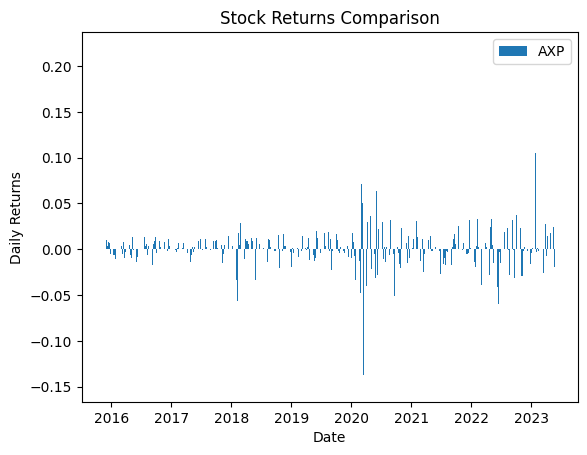

In [144]:
AXP_returns = historical['AXP'].pct_change()
PYPL_returns = historical['PYPL'].pct_change()
SQ_returns = historical['SQ'].pct_change()
GPN_returns = historical['GPN'].pct_change()
FIS_returns = historical['FIS'].pct_change()
FISV_returns = historical['FISV'].pct_change()
V_returns = historical['V'].pct_change()
MA_returns = historical['MA'].pct_change()\

# Bar plot of daily returns for each company
plt.bar(historical.index, AXP_returns, label='AXP')
# plt.bar(filtered_data.index, PYPL_returns, label='GOOG')
# plt.bar(filtered_data.index, SQ_returns, label='MSFT')
# plt.bar(filtered_data.index, GPN_returns, label='AMZN')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Stock Returns Comparison')
plt.legend()
plt.show()

In [145]:
from ipywidgets import interact, fixed, IntSlider
import datetime
def diversicheck(symbols, start_day=0, time_horizon=365, **active):
    filtered = [symbol for symbol in symbols if active.get(symbol, True)]
    prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in filtered), axis=1, keys=filtered).dropna(axis=0)
    
    
    start_dates = prices.index[0] + datetime.timedelta(days = start_day)
    end_dates = start_dates + datetime.timedelta(days=time_horizon)
    
    prices = prices.loc[start_dates:end_dates]
    
    unit_pos = prices / prices.iloc[0,:]
    basket = unit_pos.sum(axis=1) / unit_pos.shape[1]
    unit_pos.plot(figsize=(20,10),title='Stocks Cumulative Return over time', alpha=0.3)
    basket.plot(figsize=(20,10),legend = True)
    print(f'backtest from {start_dates} to {end_dates}')

# cached_data ={}
tickers = ['AXP','PYPL','SQ','GPN','FIS','FISV','V','MA']
active = dict(zip(tickers, [True] * len(tickers)))
_ = interact(diversicheck, symbols =fixed(tickers), start_day=IntSlider(min=0,max=252*10))

interactive(children=(IntSlider(value=0, description='start_day', max=2520), IntSlider(value=365, description=…

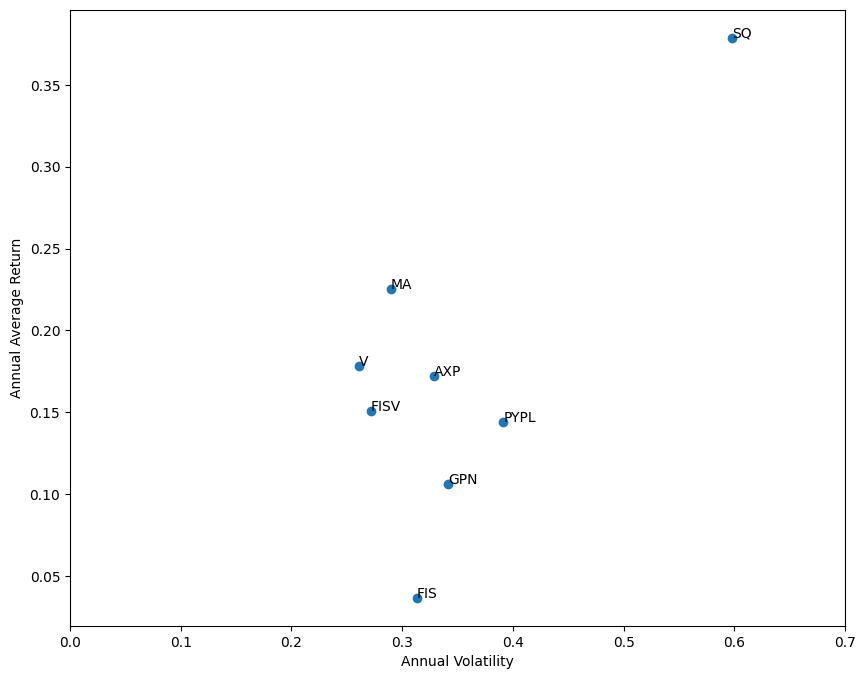

In [178]:
vols = log_returns.std() * np.sqrt(252)
avg_return = (stock_returns-1).mean()
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(vols, avg_return*252)
ax.set_xlabel('Annual Volatility')
ax.set_ylabel('Annual Average Return')
ax.set_xlim(0,0.7)
for i, txt in enumerate(tickers):
    ax.annotate(txt, xy=(vols[i], avg_return[i]*252))